# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 32  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 32]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29812.767578125
iteration 0 loss 25864.107421875


iteration 500 loss 368.2074279785156


iteration 1000 loss 292.9915771484375


iteration 1500 loss 245.6170654296875


iteration 2000 loss 217.88233947753906


iteration 2500 loss 202.356689453125


iteration 3000 loss 192.42059326171875


iteration 3500 loss 183.76751708984375


iteration 4000 loss 174.84320068359375


iteration 4500 loss 165.26258850097656


iteration 5000 loss 155.14877319335938


iteration 5500 loss 144.36683654785156


iteration 6000 loss 132.4535369873047


iteration 6500 loss 118.98802185058594


iteration 7000 loss 102.47628784179688


iteration 7500 loss 80.17269897460938


iteration 8000 loss 50.73332595825195


iteration 8500 loss 29.2103328704834


iteration 9000 loss 20.33875274658203


iteration 9500 loss 16.054780960083008


iteration 10000 loss 13.482060432434082


iteration 10500 loss 11.85299301147461


iteration 11000 loss 10.737710952758789


iteration 11500 loss 9.908146858215332


iteration 12000 loss 9.370525360107422


iteration 12500 loss 8.984612464904785


iteration 13000 loss 8.616141319274902


iteration 13500 loss 8.2891845703125


iteration 14000 loss 8.031641960144043


iteration 14500 loss 7.757991790771484


iteration 15000 loss 7.5146965980529785


iteration 15500 loss 7.314774036407471


iteration 16000 loss 7.129495143890381


iteration 16500 loss 6.97296142578125


iteration 17000 loss 6.81112813949585


iteration 17500 loss 6.676228046417236


iteration 18000 loss 6.53591775894165


iteration 18500 loss 6.415194988250732


iteration 19000 loss 6.289336204528809


iteration 19500 loss 6.1736626625061035


iteration 20000 loss 6.06171178817749


iteration 20500 loss 5.941467761993408


iteration 21000 loss 5.83278751373291


iteration 21500 loss 5.727284908294678


iteration 22000 loss 5.62430477142334


iteration 22500 loss 5.535669803619385


iteration 23000 loss 5.4391326904296875


iteration 23500 loss 5.353221893310547


iteration 24000 loss 5.258288860321045


iteration 24500 loss 5.166058540344238


iteration 25000 loss 5.061983585357666


iteration 25500 loss 4.969449996948242


iteration 26000 loss 4.879907608032227


iteration 26500 loss 4.784146308898926


iteration 27000 loss 4.71066951751709


iteration 27500 loss 4.627918243408203


iteration 28000 loss 4.561241626739502


iteration 28500 loss 4.498016357421875


iteration 29000 loss 4.426328659057617


iteration 29500 loss 4.375497817993164


iteration 30000 loss 4.315858840942383


iteration 30500 loss 4.249532699584961


iteration 31000 loss 4.192649841308594


iteration 31500 loss 4.130115509033203


iteration 32000 loss 4.080109119415283


iteration 32500 loss 4.028158664703369


iteration 33000 loss 4.055936336517334


iteration 33500 loss 3.929142951965332


iteration 34000 loss 3.8811025619506836


iteration 34500 loss 3.8397350311279297


iteration 35000 loss 3.805872678756714


iteration 35500 loss 3.7647604942321777


iteration 36000 loss 3.7302162647247314


iteration 36500 loss 3.6967861652374268


iteration 37000 loss 3.658113956451416


iteration 37500 loss 3.6313178539276123


iteration 38000 loss 3.6006252765655518


iteration 38500 loss 3.565514087677002


iteration 39000 loss 3.5411171913146973


iteration 39500 loss 3.5141096115112305


iteration 40000 loss 3.4831795692443848


iteration 40500 loss 3.4588170051574707


iteration 41000 loss 3.4332072734832764


iteration 41500 loss 3.405151128768921


iteration 42000 loss 3.3848445415496826


iteration 42500 loss 3.3604674339294434


iteration 43000 loss 3.337233543395996


iteration 43500 loss 3.316293954849243


iteration 44000 loss 3.3093678951263428


iteration 44500 loss 3.269895315170288


iteration 45000 loss 3.244774103164673


iteration 45500 loss 3.2260982990264893


iteration 46000 loss 3.2073421478271484


iteration 46500 loss 3.183576822280884


iteration 47000 loss 3.164088487625122


iteration 47500 loss 3.144542694091797


iteration 48000 loss 3.1221344470977783


iteration 48500 loss 3.105846643447876


iteration 49000 loss 3.0819153785705566


iteration 49500 loss 3.064307689666748


iteration 50000 loss 3.0437560081481934


iteration 50500 loss 3.0255775451660156


iteration 51000 loss 3.0096726417541504


iteration 51500 loss 2.9907617568969727


iteration 52000 loss 2.9712131023406982


iteration 52500 loss 2.9551074504852295


iteration 53000 loss 2.9396207332611084


iteration 53500 loss 2.9174578189849854


iteration 54000 loss 2.9044528007507324


iteration 54500 loss 2.8803069591522217


iteration 55000 loss 2.8646087646484375


iteration 55500 loss 2.843971014022827


iteration 56000 loss 2.827255964279175


iteration 56500 loss 2.808608055114746


iteration 57000 loss 2.7927019596099854


iteration 57500 loss 2.77345609664917


iteration 58000 loss 2.7572789192199707


iteration 58500 loss 2.760037899017334


iteration 59000 loss 2.725844144821167


iteration 59500 loss 2.7076199054718018


iteration 60000 loss 2.6904633045196533


iteration 60500 loss 2.6792256832122803


iteration 61000 loss 2.6595511436462402


iteration 61500 loss 2.6435940265655518


iteration 62000 loss 2.6369500160217285


iteration 62500 loss 2.610599994659424


iteration 63000 loss 2.596982002258301


iteration 63500 loss 2.5778331756591797


iteration 64000 loss 2.564826011657715


iteration 64500 loss 2.5482943058013916


iteration 65000 loss 2.530337333679199


iteration 65500 loss 2.514531135559082


iteration 66000 loss 2.4971418380737305


iteration 66500 loss 2.483036518096924


iteration 67000 loss 2.463526964187622


iteration 67500 loss 2.4492180347442627


iteration 68000 loss 2.4303650856018066


iteration 68500 loss 2.4143900871276855


iteration 69000 loss 2.3970518112182617


iteration 69500 loss 2.3889687061309814


iteration 70000 loss 2.3636081218719482


iteration 70500 loss 2.3479740619659424


iteration 71000 loss 2.3299002647399902


iteration 71500 loss 2.3179595470428467


iteration 72000 loss 2.297464370727539


iteration 72500 loss 2.2899351119995117


iteration 73000 loss 2.2628085613250732


iteration 73500 loss 2.2469866275787354


iteration 74000 loss 2.229342222213745


iteration 74500 loss 2.213165283203125


iteration 75000 loss 2.196138858795166


iteration 75500 loss 2.183039426803589


iteration 76000 loss 2.181201934814453


iteration 76500 loss 2.1451802253723145


iteration 77000 loss 2.1410646438598633


iteration 77500 loss 2.1193835735321045


iteration 78000 loss 2.107067346572876


iteration 78500 loss 2.076477289199829


iteration 79000 loss 2.062049150466919


iteration 79500 loss 2.1102945804595947


iteration 80000 loss 2.044008731842041


iteration 80500 loss 2.0249276161193848


iteration 81000 loss 2.0110840797424316


iteration 81500 loss 2.0091476440429688


iteration 82000 loss 1.9631409645080566


iteration 82500 loss 1.951265811920166


iteration 83000 loss 1.9325000047683716


iteration 83500 loss 1.9141870737075806


iteration 84000 loss 1.8978608846664429


iteration 84500 loss 1.8827415704727173


iteration 85000 loss 1.865896224975586


iteration 85500 loss 1.8498151302337646


iteration 86000 loss 1.833404779434204


iteration 86500 loss 1.8274872303009033


iteration 87000 loss 1.8044354915618896


iteration 87500 loss 1.7932159900665283


iteration 88000 loss 1.7696155309677124


iteration 88500 loss 1.7539530992507935


iteration 89000 loss 1.7600383758544922


iteration 89500 loss 1.7268503904342651


iteration 90000 loss 1.7149664163589478


iteration 90500 loss 1.702271819114685


iteration 91000 loss 1.6780140399932861


iteration 91500 loss 1.6625707149505615


iteration 92000 loss 1.6499574184417725


iteration 92500 loss 1.6326255798339844


iteration 93000 loss 1.6178711652755737


iteration 93500 loss 1.603248953819275


iteration 94000 loss 1.5893335342407227


iteration 94500 loss 1.5747206211090088


iteration 95000 loss 1.5609428882598877


iteration 95500 loss 1.5467866659164429


iteration 96000 loss 1.6262730360031128


iteration 96500 loss 1.5186896324157715


iteration 97000 loss 1.5530036687850952


iteration 97500 loss 1.492163062095642


iteration 98000 loss 1.5000773668289185


iteration 98500 loss 1.4654275178909302


iteration 99000 loss 1.461165428161621


iteration 99500 loss 1.44267737865448


iteration 100000 loss 1.4255160093307495


iteration 100500 loss 1.4134929180145264


iteration 101000 loss 1.400446891784668


iteration 101500 loss 1.3890273571014404


iteration 102000 loss 1.3760955333709717


iteration 102500 loss 1.3642395734786987


iteration 103000 loss 1.7581182718276978


iteration 103500 loss 1.371681809425354


iteration 104000 loss 1.3320990800857544


iteration 104500 loss 1.3174246549606323


iteration 105000 loss 1.4126384258270264


iteration 105500 loss 1.2944467067718506


iteration 106000 loss 1.2844421863555908


iteration 106500 loss 1.273276686668396


iteration 107000 loss 1.2624298334121704


iteration 107500 loss 1.2518599033355713


iteration 108000 loss 1.4598870277404785


iteration 108500 loss 1.2313921451568604


iteration 109000 loss 1.2212141752243042


iteration 109500 loss 1.2600687742233276


iteration 110000 loss 1.2017956972122192


iteration 110500 loss 1.1920809745788574


iteration 111000 loss 1.1827976703643799


iteration 111500 loss 1.5204787254333496


iteration 112000 loss 1.165218472480774


iteration 112500 loss 1.1564947366714478


iteration 113000 loss 1.161171555519104


iteration 113500 loss 1.1378824710845947


iteration 114000 loss 1.129503846168518


iteration 114500 loss 1.1221249103546143


iteration 115000 loss 1.1138463020324707


iteration 115500 loss 1.1046522855758667


iteration 116000 loss 1.2020014524459839


iteration 116500 loss 1.2220178842544556


iteration 117000 loss 1.089722990989685


iteration 117500 loss 1.0823376178741455


iteration 118000 loss 1.0661511421203613


iteration 118500 loss 1.1248910427093506


iteration 119000 loss 1.0646005868911743


iteration 119500 loss 1.052778720855713


iteration 120000 loss 1.061445713043213


iteration 120500 loss 1.0413633584976196


iteration 121000 loss 1.1231178045272827


iteration 121500 loss 1.0168097019195557


iteration 122000 loss 1.0131253004074097


iteration 122500 loss 1.2454805374145508


iteration 123000 loss 0.9962847232818604


iteration 123500 loss 1.1097111701965332


iteration 124000 loss 0.9902230501174927


iteration 124500 loss 0.9786132574081421


iteration 125000 loss 1.008197546005249


iteration 125500 loss 0.9779505729675293


iteration 126000 loss 0.9590041637420654


iteration 126500 loss 0.9539130330085754


iteration 127000 loss 0.94717937707901


iteration 127500 loss 0.9415555596351624


iteration 128000 loss 0.935849666595459


iteration 128500 loss 0.9310867190361023


iteration 129000 loss 0.9479818940162659


iteration 129500 loss 1.1568570137023926


iteration 130000 loss 1.1318821907043457


iteration 130500 loss 0.9094720482826233


iteration 131000 loss 0.932120680809021


iteration 131500 loss 0.898381233215332


iteration 132000 loss 0.9182912111282349


iteration 132500 loss 0.9343603253364563


iteration 133000 loss 0.8841609358787537


iteration 133500 loss 0.8781749606132507


iteration 134000 loss 1.2465869188308716


iteration 134500 loss 0.8684729337692261


iteration 135000 loss 0.8637475371360779


iteration 135500 loss 0.8591251969337463


iteration 136000 loss 1.155421495437622


iteration 136500 loss 0.8499906063079834


iteration 137000 loss 0.9024843573570251


iteration 137500 loss 0.840999186038971


iteration 138000 loss 0.8366782069206238


iteration 138500 loss 0.94291752576828


iteration 139000 loss 0.8282729983329773


iteration 139500 loss 0.8419486284255981


iteration 140000 loss 0.8463769555091858


iteration 140500 loss 0.8154898285865784


iteration 141000 loss 1.0556310415267944


iteration 141500 loss 0.8273366689682007


iteration 142000 loss 0.8549405932426453


iteration 142500 loss 0.7998239398002625


iteration 143000 loss 0.9434559345245361


iteration 143500 loss 0.7958443760871887


iteration 144000 loss 0.7889944911003113


iteration 144500 loss 0.8060019016265869


iteration 145000 loss 0.911514937877655


iteration 145500 loss 0.8024600744247437


iteration 146000 loss 0.7790548801422119


iteration 146500 loss 1.3554965257644653


iteration 147000 loss 0.7660627961158752


iteration 147500 loss 0.7627742886543274


iteration 148000 loss 0.766228437423706


iteration 148500 loss 0.7674970626831055


iteration 149000 loss 0.7549298405647278


iteration 149500 loss 0.7823117971420288


iteration 150000 loss 0.7565788626670837


iteration 150500 loss 0.7432149052619934


iteration 151000 loss 0.7388961911201477


iteration 151500 loss 0.7464836835861206


iteration 152000 loss 0.7334868907928467


iteration 152500 loss 0.7444131374359131


iteration 153000 loss 0.7259721755981445


iteration 153500 loss 0.7236777544021606


iteration 154000 loss 0.754194438457489


iteration 154500 loss 0.7169077396392822


iteration 155000 loss 0.7273615002632141


iteration 155500 loss 0.7153798937797546


iteration 156000 loss 0.7084011435508728


iteration 156500 loss 0.7051586508750916


iteration 157000 loss 0.7373831868171692


iteration 157500 loss 0.6991627812385559


iteration 158000 loss 0.6971171498298645


iteration 158500 loss 0.8982827663421631


iteration 159000 loss 0.7650899291038513


iteration 159500 loss 0.7263806462287903


iteration 160000 loss 0.6866671442985535


iteration 160500 loss 0.8786529302597046


iteration 161000 loss 0.6805323958396912


iteration 161500 loss 0.6787496209144592


iteration 162000 loss 0.6755974292755127


iteration 162500 loss 0.6727371215820312


iteration 163000 loss 0.684309184551239


iteration 163500 loss 0.6671451926231384


iteration 164000 loss 0.6643996834754944


iteration 164500 loss 0.6890734434127808


iteration 165000 loss 0.6625882387161255


iteration 165500 loss 0.8825113773345947


iteration 166000 loss 0.7385293841362


iteration 166500 loss 0.6574516892433167


iteration 167000 loss 0.6504132747650146


iteration 167500 loss 0.6514427661895752


iteration 168000 loss 0.7213751673698425


iteration 168500 loss 0.6430436372756958


iteration 169000 loss 0.6563951969146729


iteration 169500 loss 0.9769068360328674


iteration 170000 loss 0.6367195844650269


iteration 170500 loss 0.6368439197540283


iteration 171000 loss 0.632289707660675


iteration 171500 loss 0.630624532699585


iteration 172000 loss 0.6273738145828247


iteration 172500 loss 0.6326354742050171


iteration 173000 loss 0.6290661692619324


iteration 173500 loss 0.6384071111679077


iteration 174000 loss 0.6283745169639587


iteration 174500 loss 0.6175567507743835


iteration 175000 loss 0.6621963977813721


iteration 175500 loss 0.6133060455322266


iteration 176000 loss 0.6129485964775085


iteration 176500 loss 0.7177119255065918


iteration 177000 loss 0.6074538826942444


iteration 177500 loss 0.6048958897590637


iteration 178000 loss 0.6441783905029297


iteration 178500 loss 0.6015469431877136


iteration 179000 loss 0.6634739637374878


iteration 179500 loss 0.5988720059394836


iteration 180000 loss 0.5993849635124207


iteration 180500 loss 0.6077172756195068


iteration 181000 loss 0.5927379727363586


iteration 181500 loss 0.597729504108429


iteration 182000 loss 0.6181589961051941


iteration 182500 loss 0.5876264572143555


iteration 183000 loss 1.6310099363327026


iteration 183500 loss 0.5950693488121033


iteration 184000 loss 0.583884060382843


iteration 184500 loss 0.5794630646705627


iteration 185000 loss 0.5836623907089233


iteration 185500 loss 0.5768812894821167


iteration 186000 loss 0.5816240310668945


iteration 186500 loss 0.5728772282600403


iteration 187000 loss 0.6038625240325928


iteration 187500 loss 0.5700346231460571


iteration 188000 loss 0.653057336807251


iteration 188500 loss 0.6399490237236023


iteration 189000 loss 0.7070627212524414


iteration 189500 loss 0.5994178056716919


iteration 190000 loss 0.5623396635055542


iteration 190500 loss 0.5602214932441711


iteration 191000 loss 0.5817328095436096


iteration 191500 loss 0.5582751631736755


iteration 192000 loss 0.5577257871627808


iteration 192500 loss 0.5828388929367065


iteration 193000 loss 0.5532280206680298


iteration 193500 loss 0.5515447854995728


iteration 194000 loss 0.7883427739143372


iteration 194500 loss 0.5639196038246155


iteration 195000 loss 0.5469224452972412


iteration 195500 loss 0.8533273935317993


iteration 196000 loss 0.547336995601654


iteration 196500 loss 0.5458219647407532


iteration 197000 loss 0.6076058149337769


iteration 197500 loss 0.7398450970649719


iteration 198000 loss 0.5384047031402588


iteration 198500 loss 0.6745119690895081


iteration 199000 loss 0.6203379034996033


iteration 199500 loss 0.5423625111579895


iteration 200000 loss 0.6731516718864441


iteration 200500 loss 0.5401036739349365


iteration 201000 loss 0.5583810210227966


iteration 201500 loss 0.5816591382026672


iteration 202000 loss 0.7248603105545044


iteration 202500 loss 1.5904266834259033


iteration 203000 loss 0.5545669794082642


iteration 203500 loss 0.5248751044273376


iteration 204000 loss 0.5238201022148132


iteration 204500 loss 0.5342918038368225


iteration 205000 loss 0.5196949243545532


iteration 205500 loss 0.5277124047279358


iteration 206000 loss 0.5212214589118958


iteration 206500 loss 0.5228673219680786


iteration 207000 loss 0.5325894951820374


iteration 207500 loss 0.5175188183784485


iteration 208000 loss 0.987113356590271


iteration 208500 loss 0.7678290605545044


iteration 209000 loss 0.5875343680381775


iteration 209500 loss 0.5671341419219971


iteration 210000 loss 0.5111915469169617


iteration 210500 loss 0.5595481991767883


iteration 211000 loss 0.5136960744857788


iteration 211500 loss 0.5446234345436096


iteration 212000 loss 0.5675684213638306


iteration 212500 loss 0.50220787525177


iteration 213000 loss 0.5506943464279175


iteration 213500 loss 0.5010053515434265


iteration 214000 loss 1.3208379745483398


iteration 214500 loss 0.5054547786712646


iteration 215000 loss 0.574242353439331


iteration 215500 loss 0.5001078248023987


iteration 216000 loss 0.496463418006897


iteration 216500 loss 0.5094418525695801


iteration 217000 loss 0.7082986831665039


iteration 217500 loss 0.5213648080825806


iteration 218000 loss 0.5951923727989197


iteration 218500 loss 0.5103857517242432


iteration 219000 loss 0.49008825421333313


iteration 219500 loss 0.6123071312904358


iteration 220000 loss 0.97843998670578


iteration 220500 loss 0.4905671775341034


iteration 221000 loss 0.4897797703742981


iteration 221500 loss 0.4857179522514343


iteration 222000 loss 0.7231404781341553


iteration 222500 loss 0.4960412085056305


iteration 223000 loss 0.5532342791557312


iteration 223500 loss 0.6228143572807312


iteration 224000 loss 0.4811083972454071


iteration 224500 loss 0.49182283878326416


iteration 225000 loss 0.477067768573761


iteration 225500 loss 0.47544538974761963


iteration 226000 loss 0.47520795464515686


iteration 226500 loss 0.4876437783241272


iteration 227000 loss 0.4753333032131195


iteration 227500 loss 0.4796160161495209


iteration 228000 loss 0.9519844651222229


iteration 228500 loss 0.48999080061912537


iteration 229000 loss 1.0378553867340088


iteration 229500 loss 0.46892595291137695


iteration 230000 loss 0.46791985630989075


iteration 230500 loss 0.47011709213256836


iteration 231000 loss 0.5615596175193787


iteration 231500 loss 0.466388463973999


iteration 232000 loss 0.4706277847290039


iteration 232500 loss 0.6054698824882507


iteration 233000 loss 0.4624442160129547


iteration 233500 loss 0.46248435974121094


iteration 234000 loss 0.584501326084137


iteration 234500 loss 0.4647933542728424


iteration 235000 loss 0.48501044511795044


iteration 235500 loss 0.4599038064479828


iteration 236000 loss 0.4573296904563904


iteration 236500 loss 0.45965906977653503


iteration 237000 loss 0.8105663657188416


iteration 237500 loss 0.8395514488220215


iteration 238000 loss 0.4547170400619507


iteration 238500 loss 0.45738548040390015


iteration 239000 loss 0.7580934166908264


iteration 239500 loss 0.4510995149612427


iteration 240000 loss 0.4635240137577057


iteration 240500 loss 0.45105019211769104


iteration 241000 loss 0.45459887385368347


iteration 241500 loss 0.5208770036697388


iteration 242000 loss 0.44862204790115356


iteration 242500 loss 0.507561206817627


iteration 243000 loss 0.46558767557144165


iteration 243500 loss 0.4689120948314667


iteration 244000 loss 0.4445917010307312


iteration 244500 loss 0.5116958022117615


iteration 245000 loss 0.4485056400299072


iteration 245500 loss 0.4557366967201233


iteration 246000 loss 0.4710645377635956


iteration 246500 loss 0.5957236886024475


iteration 247000 loss 0.5797951817512512


iteration 247500 loss 0.5266844034194946


iteration 248000 loss 0.5707062482833862


iteration 248500 loss 0.4384814202785492


iteration 249000 loss 0.43918201327323914


iteration 249500 loss 0.448883056640625


iteration 250000 loss 0.46310195326805115


iteration 250500 loss 0.45549675822257996


iteration 251000 loss 0.43464285135269165


iteration 251500 loss 0.44497382640838623


iteration 252000 loss 0.6478844285011292


iteration 252500 loss 0.45167532563209534


iteration 253000 loss 1.2838917970657349


iteration 253500 loss 0.49004843831062317


iteration 254000 loss 0.46492576599121094


iteration 254500 loss 0.5301830172538757


iteration 255000 loss 0.496796578168869


iteration 255500 loss 0.47244852781295776


iteration 256000 loss 0.5028590559959412


iteration 256500 loss 0.7596275210380554


iteration 257000 loss 0.42798349261283875


iteration 257500 loss 0.45628464221954346


iteration 258000 loss 0.42493826150894165


iteration 258500 loss 0.4367476999759674


iteration 259000 loss 0.4875618517398834


iteration 259500 loss 0.42419353127479553


iteration 260000 loss 0.42438772320747375


iteration 260500 loss 0.4246364235877991


iteration 261000 loss 0.6089871525764465


iteration 261500 loss 0.4419550597667694


iteration 262000 loss 0.44529062509536743


iteration 262500 loss 0.4853264391422272


iteration 263000 loss 0.43377092480659485


iteration 263500 loss 0.4180343747138977


iteration 264000 loss 0.41708847880363464


iteration 264500 loss 0.5998376607894897


iteration 265000 loss 0.5672582983970642


iteration 265500 loss 0.427253395318985


iteration 266000 loss 0.4151259660720825


iteration 266500 loss 0.423972487449646


iteration 267000 loss 0.5765950679779053


iteration 267500 loss 0.44758787751197815


iteration 268000 loss 0.5813683271408081


iteration 268500 loss 0.8654088377952576


iteration 269000 loss 0.4296359121799469


iteration 269500 loss 0.5605961084365845


iteration 270000 loss 0.5359266400337219


iteration 270500 loss 1.2346287965774536


iteration 271000 loss 0.5615900754928589


iteration 271500 loss 0.48225468397140503


iteration 272000 loss 0.6404240131378174


iteration 272500 loss 0.40924072265625


iteration 273000 loss 0.4226081371307373


iteration 273500 loss 0.4225582778453827


iteration 274000 loss 0.4843504726886749


iteration 274500 loss 0.40513134002685547


iteration 275000 loss 0.40983182191848755


iteration 275500 loss 0.574062168598175


iteration 276000 loss 0.4324724078178406


iteration 276500 loss 0.4617423713207245


iteration 277000 loss 0.4130227565765381


iteration 277500 loss 0.51954185962677


iteration 278000 loss 0.4595538079738617


iteration 278500 loss 0.4145132303237915


iteration 279000 loss 0.4061664640903473


iteration 279500 loss 0.539073646068573


iteration 280000 loss 0.4170447289943695


iteration 280500 loss 0.43778592348098755


iteration 281000 loss 0.4218844473361969


iteration 281500 loss 0.39892899990081787


iteration 282000 loss 0.40000423789024353


iteration 282500 loss 0.4332926571369171


iteration 283000 loss 0.4658925533294678


iteration 283500 loss 0.3999432623386383


iteration 284000 loss 0.5332794785499573


iteration 284500 loss 0.39731499552726746


iteration 285000 loss 0.40035268664360046


iteration 285500 loss 0.6532909274101257


iteration 286000 loss 0.3965192139148712


iteration 286500 loss 0.42438486218452454


iteration 287000 loss 0.5917344689369202


iteration 287500 loss 0.39253637194633484


iteration 288000 loss 0.4504585862159729


iteration 288500 loss 0.622600257396698


iteration 289000 loss 0.39098602533340454


iteration 289500 loss 0.41578418016433716


iteration 290000 loss 0.46624550223350525


iteration 290500 loss 0.3930928707122803


iteration 291000 loss 0.3970978856086731


iteration 291500 loss 0.3922688066959381


iteration 292000 loss 0.39169207215309143


iteration 292500 loss 0.4129529595375061


iteration 293000 loss 0.38934651017189026


iteration 293500 loss 0.5640530586242676


iteration 294000 loss 0.3884912431240082


iteration 294500 loss 0.3864753842353821


iteration 295000 loss 0.38589975237846375


iteration 295500 loss 0.42913055419921875


iteration 296000 loss 0.7628787159919739


iteration 296500 loss 0.5519503951072693


iteration 297000 loss 0.5375787019729614


iteration 297500 loss 0.3937798738479614


iteration 298000 loss 0.44827449321746826


iteration 298500 loss 0.38949981331825256


iteration 299000 loss 0.41593295335769653


iteration 299500 loss 0.6954739093780518


iteration 300000 loss 0.44151952862739563


iteration 300500 loss 0.38628271222114563


iteration 301000 loss 0.6042672991752625


iteration 301500 loss 0.38733747601509094


iteration 302000 loss 0.5826246738433838


iteration 302500 loss 0.9052673578262329


iteration 303000 loss 0.37991631031036377


iteration 303500 loss 0.5095949769020081


iteration 304000 loss 0.3757871985435486


iteration 304500 loss 0.3757278323173523


iteration 305000 loss 0.3979789614677429


iteration 305500 loss 0.38246312737464905


iteration 306000 loss 0.5416141748428345


iteration 306500 loss 0.6532906889915466


iteration 307000 loss 0.4026661217212677


iteration 307500 loss 0.443221777677536


iteration 308000 loss 0.3732702136039734


iteration 308500 loss 0.4114185571670532


iteration 309000 loss 0.6612585186958313


iteration 309500 loss 0.3711559474468231


iteration 310000 loss 0.374651163816452


iteration 310500 loss 0.37611472606658936


iteration 311000 loss 0.37362608313560486


iteration 311500 loss 0.8288328647613525


iteration 312000 loss 0.3702923357486725


iteration 312500 loss 0.4482484757900238


iteration 313000 loss 0.4271151125431061


iteration 313500 loss 0.389622300863266


iteration 314000 loss 0.8194286823272705


iteration 314500 loss 0.3795596659183502


iteration 315000 loss 0.3663233816623688


iteration 315500 loss 0.3691975772380829


iteration 316000 loss 0.3953426778316498


iteration 316500 loss 0.3650609254837036


iteration 317000 loss 0.39663249254226685


iteration 317500 loss 0.36504629254341125


iteration 318000 loss 0.3649595379829407


iteration 318500 loss 0.41136035323143005


iteration 319000 loss 0.3801283538341522


iteration 319500 loss 0.3642275035381317


iteration 320000 loss 1.1957340240478516


iteration 320500 loss 0.391608327627182


iteration 321000 loss 0.36905184388160706


iteration 321500 loss 0.3871288299560547


iteration 322000 loss 0.37060531973838806


iteration 322500 loss 0.5501269698143005


iteration 323000 loss 0.37307533621788025


iteration 323500 loss 0.3756251931190491


iteration 324000 loss 0.39262479543685913


iteration 324500 loss 0.4096318185329437


iteration 325000 loss 0.37040096521377563


iteration 325500 loss 0.8275372982025146


iteration 326000 loss 0.361088365316391


iteration 326500 loss 0.9046170711517334


iteration 327000 loss 0.46044135093688965


iteration 327500 loss 0.3972306251525879


iteration 328000 loss 0.35671696066856384


iteration 328500 loss 0.4872317314147949


iteration 329000 loss 0.3594706952571869


iteration 329500 loss 0.3663208782672882


iteration 330000 loss 0.47304797172546387


iteration 330500 loss 0.44796717166900635


iteration 331000 loss 0.5435397028923035


iteration 331500 loss 0.3858294188976288


iteration 332000 loss 0.3820914328098297


iteration 332500 loss 1.0006643533706665


iteration 333000 loss 0.4000018537044525


iteration 333500 loss 0.3671666383743286


iteration 334000 loss 0.3761844038963318


iteration 334500 loss 0.6524772047996521


iteration 335000 loss 0.37468767166137695


iteration 335500 loss 0.35347405076026917


iteration 336000 loss 0.5178816318511963


iteration 336500 loss 0.7001456618309021


iteration 337000 loss 0.35316476225852966


iteration 337500 loss 0.4054493010044098


iteration 338000 loss 0.35497114062309265


iteration 338500 loss 0.354114830493927


iteration 339000 loss 0.35104408860206604


iteration 339500 loss 0.7178360223770142


iteration 340000 loss 0.3574802577495575


iteration 340500 loss 0.618770182132721


iteration 341000 loss 0.3580726087093353


iteration 341500 loss 0.36555179953575134


iteration 342000 loss 0.3468940854072571


iteration 342500 loss 0.3589548170566559


iteration 343000 loss 0.5533252358436584


iteration 343500 loss 0.5031002759933472


iteration 344000 loss 0.3472374975681305


iteration 344500 loss 0.7532811164855957


iteration 345000 loss 0.3482202887535095


iteration 345500 loss 0.3684430718421936


iteration 346000 loss 0.35991960763931274


iteration 346500 loss 0.4106235206127167


iteration 347000 loss 0.3944840133190155


iteration 347500 loss 0.4495656192302704


iteration 348000 loss 0.34729233384132385


iteration 348500 loss 0.3450468182563782


iteration 349000 loss 0.40035364031791687


iteration 349500 loss 0.3510435223579407


iteration 350000 loss 0.34223130345344543


iteration 350500 loss 0.6861398220062256


iteration 351000 loss 0.4284338653087616


iteration 351500 loss 0.3793965280056


iteration 352000 loss 0.34157615900039673


iteration 352500 loss 0.3555033504962921


iteration 353000 loss 0.3543528616428375


iteration 353500 loss 0.39518922567367554


iteration 354000 loss 0.5798607468605042


iteration 354500 loss 0.5218520760536194


iteration 355000 loss 0.8959543704986572


iteration 355500 loss 0.34509211778640747


iteration 356000 loss 0.43806853890419006


iteration 356500 loss 0.3385937809944153


iteration 357000 loss 0.8085854649543762


iteration 357500 loss 0.33874931931495667


iteration 358000 loss 0.35531628131866455


iteration 358500 loss 0.3405885100364685


iteration 359000 loss 0.33777886629104614


iteration 359500 loss 0.4029342234134674


iteration 360000 loss 0.45460057258605957


iteration 360500 loss 0.4820942282676697


iteration 361000 loss 0.3377265930175781


iteration 361500 loss 0.3370841443538666


iteration 362000 loss 0.34965112805366516


iteration 362500 loss 0.6804856061935425


iteration 363000 loss 0.40827837586402893


iteration 363500 loss 0.3341798484325409


iteration 364000 loss 0.3386772871017456


iteration 364500 loss 0.3542454242706299


iteration 365000 loss 0.5799342393875122


iteration 365500 loss 0.33375686407089233


iteration 366000 loss 0.34052419662475586


iteration 366500 loss 0.3707779347896576


iteration 367000 loss 0.3356075882911682


iteration 367500 loss 0.3979598581790924


iteration 368000 loss 0.5231194496154785


iteration 368500 loss 0.5352663397789001


iteration 369000 loss 0.3403153419494629


iteration 369500 loss 0.374419242143631


iteration 370000 loss 0.3670467734336853


iteration 370500 loss 0.3502301573753357


iteration 371000 loss 0.3466998040676117


iteration 371500 loss 0.3505007028579712


iteration 372000 loss 0.359151154756546


iteration 372500 loss 0.3618929386138916


iteration 373000 loss 0.3515268564224243


iteration 373500 loss 0.5913850665092468


iteration 374000 loss 0.7586033940315247


iteration 374500 loss 0.35264256596565247


iteration 375000 loss 0.3384369909763336


iteration 375500 loss 0.850584864616394


iteration 376000 loss 0.3269895017147064


iteration 376500 loss 0.3691016137599945


iteration 377000 loss 0.33851051330566406


iteration 377500 loss 0.32851001620292664


iteration 378000 loss 0.34049350023269653


iteration 378500 loss 0.46710205078125


iteration 379000 loss 0.4020245671272278


iteration 379500 loss 1.5450974702835083


iteration 380000 loss 0.32629141211509705


iteration 380500 loss 0.42869314551353455


iteration 381000 loss 0.36394980549812317


iteration 381500 loss 0.4324234127998352


iteration 382000 loss 0.3485671877861023


iteration 382500 loss 0.3249830901622772


iteration 383000 loss 0.3692575693130493


iteration 383500 loss 0.3403978645801544


iteration 384000 loss 0.3249572217464447


iteration 384500 loss 0.804374098777771


iteration 385000 loss 0.49462807178497314


iteration 385500 loss 0.43650466203689575


iteration 386000 loss 0.3347415030002594


iteration 386500 loss 1.6447683572769165


iteration 387000 loss 0.32245466113090515


iteration 387500 loss 1.6516417264938354


iteration 388000 loss 0.32065093517303467


iteration 388500 loss 0.5452073812484741


iteration 389000 loss 0.3248291611671448


iteration 389500 loss 0.34844979643821716


iteration 390000 loss 0.8646289110183716


iteration 390500 loss 1.257262110710144


iteration 391000 loss 0.3206045925617218


iteration 391500 loss 0.37559187412261963


iteration 392000 loss 0.3328703045845032


iteration 392500 loss 0.3319608271121979


iteration 393000 loss 0.49120864272117615


iteration 393500 loss 0.397878497838974


iteration 394000 loss 0.3663704991340637


iteration 394500 loss 0.32017984986305237


iteration 395000 loss 0.42789170145988464


iteration 395500 loss 1.105955958366394


iteration 396000 loss 0.319942831993103


iteration 396500 loss 0.6772316694259644


iteration 397000 loss 1.1278754472732544


iteration 397500 loss 0.35791948437690735


iteration 398000 loss 0.8141118884086609


iteration 398500 loss 0.32631438970565796


iteration 399000 loss 0.3276074528694153


iteration 399500 loss 0.3278043568134308


iteration 400000 loss 0.3369385302066803


iteration 400500 loss 1.019790530204773


iteration 401000 loss 0.4332626760005951


iteration 401500 loss 0.31688424944877625


iteration 402000 loss 0.34974735975265503


iteration 402500 loss 0.5906323790550232


iteration 403000 loss 0.34092870354652405


iteration 403500 loss 0.3186386525630951


iteration 404000 loss 0.31669187545776367


iteration 404500 loss 0.3586067259311676


iteration 405000 loss 0.4030759632587433


iteration 405500 loss 0.8582712411880493


iteration 406000 loss 0.3239750862121582


iteration 406500 loss 0.3157527446746826


iteration 407000 loss 0.33722561597824097


iteration 407500 loss 0.3161144554615021


iteration 408000 loss 0.3514105975627899


iteration 408500 loss 0.8323375582695007


iteration 409000 loss 0.37547391653060913


iteration 409500 loss 0.3231375515460968


iteration 410000 loss 0.34175416827201843


iteration 410500 loss 0.7014871835708618


iteration 411000 loss 0.32476362586021423


iteration 411500 loss 0.9217280745506287


iteration 412000 loss 0.3394867479801178


iteration 412500 loss 0.438099205493927


iteration 413000 loss 0.41700395941734314


iteration 413500 loss 0.40506264567375183


iteration 414000 loss 0.33995452523231506


iteration 414500 loss 0.33778923749923706


iteration 415000 loss 0.3112046718597412


iteration 415500 loss 0.32269030809402466


iteration 416000 loss 0.6306582689285278


iteration 416500 loss 0.37988147139549255


iteration 417000 loss 0.5133435130119324


iteration 417500 loss 0.40451252460479736


iteration 418000 loss 0.31422871351242065


iteration 418500 loss 0.32799530029296875


iteration 419000 loss 0.3444463312625885


iteration 419500 loss 0.3119692802429199


iteration 420000 loss 0.36118677258491516


iteration 420500 loss 0.4243170917034149


iteration 421000 loss 0.31216585636138916


iteration 421500 loss 0.3448268473148346


iteration 422000 loss 0.3330601453781128


iteration 422500 loss 0.31875887513160706


iteration 423000 loss 0.4968976378440857


iteration 423500 loss 0.30660539865493774


iteration 424000 loss 0.3520122766494751


iteration 424500 loss 0.34963738918304443


iteration 425000 loss 0.43545547127723694


iteration 425500 loss 0.30602073669433594


iteration 426000 loss 0.3114105463027954


iteration 426500 loss 0.5041260123252869


iteration 427000 loss 0.30645236372947693


iteration 427500 loss 0.30927181243896484


iteration 428000 loss 0.4209018051624298


iteration 428500 loss 0.36010995507240295


iteration 429000 loss 0.31676599383354187


iteration 429500 loss 0.44532155990600586


iteration 430000 loss 0.38075369596481323


iteration 430500 loss 0.3058917224407196


iteration 431000 loss 0.876179575920105


iteration 431500 loss 0.32166606187820435


iteration 432000 loss 0.34173983335494995


iteration 432500 loss 0.34857138991355896


iteration 433000 loss 0.34122568368911743


iteration 433500 loss 0.4011918902397156


iteration 434000 loss 0.3039020299911499


iteration 434500 loss 0.3180405795574188


iteration 435000 loss 0.5591180324554443


iteration 435500 loss 0.45226186513900757


iteration 436000 loss 0.5054135322570801


iteration 436500 loss 0.558104395866394


iteration 437000 loss 0.3486940860748291


iteration 437500 loss 0.40476536750793457


iteration 438000 loss 0.39219608902931213


iteration 438500 loss 0.326924592256546


iteration 439000 loss 0.4916466772556305


iteration 439500 loss 0.6917018294334412


iteration 440000 loss 0.3160337209701538


iteration 440500 loss 0.3112431466579437


iteration 441000 loss 0.5793411135673523


iteration 441500 loss 0.31266841292381287


iteration 442000 loss 0.37958669662475586


iteration 442500 loss 0.37304744124412537


iteration 443000 loss 0.305867075920105


iteration 443500 loss 0.3104056417942047


iteration 444000 loss 0.3780252933502197


iteration 444500 loss 0.2981242537498474


iteration 445000 loss 0.5560502409934998


iteration 445500 loss 0.483734667301178


iteration 446000 loss 0.5267646312713623


iteration 446500 loss 0.5273903608322144


iteration 447000 loss 0.34268447756767273


iteration 447500 loss 0.32623064517974854


iteration 448000 loss 0.30659839510917664


iteration 448500 loss 0.3020423650741577


iteration 449000 loss 0.3504886031150818


iteration 449500 loss 0.3265332877635956


iteration 450000 loss 0.29578259587287903


iteration 450500 loss 0.2953518033027649


iteration 451000 loss 0.32180020213127136


iteration 451500 loss 0.297600656747818


iteration 452000 loss 0.29577651619911194


iteration 452500 loss 0.37945741415023804


iteration 453000 loss 0.8677453994750977


iteration 453500 loss 0.2981634736061096


iteration 454000 loss 0.4697491526603699


iteration 454500 loss 0.3359546661376953


iteration 455000 loss 0.30263176560401917


iteration 455500 loss 0.2997246980667114


iteration 456000 loss 0.30510571599006653


iteration 456500 loss 0.3298020362854004


iteration 457000 loss 0.31919804215431213


iteration 457500 loss 1.5059720277786255


iteration 458000 loss 0.3131547272205353


iteration 458500 loss 0.4365765452384949


iteration 459000 loss 0.42354774475097656


iteration 459500 loss 0.3588217794895172


iteration 460000 loss 0.3025478422641754


iteration 460500 loss 0.3433845341205597


iteration 461000 loss 0.5552182793617249


iteration 461500 loss 0.3992648124694824


iteration 462000 loss 0.3255828022956848


iteration 462500 loss 0.4468149244785309


iteration 463000 loss 0.33763280510902405


iteration 463500 loss 0.35221433639526367


iteration 464000 loss 0.3029015064239502


iteration 464500 loss 0.2954529821872711


iteration 465000 loss 0.2963077127933502


iteration 465500 loss 0.29249751567840576


iteration 466000 loss 0.5515390038490295


iteration 466500 loss 0.31025931239128113


iteration 467000 loss 0.576958954334259


iteration 467500 loss 0.30781611800193787


iteration 468000 loss 0.29625776410102844


iteration 468500 loss 0.29671189188957214


iteration 469000 loss 0.3098645508289337


iteration 469500 loss 0.7037407755851746


iteration 470000 loss 0.3379843533039093


iteration 470500 loss 0.3299436867237091


iteration 471000 loss 0.526707112789154


iteration 471500 loss 0.37838029861450195


iteration 472000 loss 0.42848846316337585


iteration 472500 loss 0.2965930104255676


iteration 473000 loss 0.559707760810852


iteration 473500 loss 0.3221956491470337


iteration 474000 loss 0.5284661054611206


iteration 474500 loss 0.6765444874763489


iteration 475000 loss 0.2882751524448395


iteration 475500 loss 0.2900386452674866


iteration 476000 loss 0.3430558145046234


iteration 476500 loss 0.312619149684906


iteration 477000 loss 0.2959940731525421


iteration 477500 loss 0.3785631060600281


iteration 478000 loss 0.440231055021286


iteration 478500 loss 0.42808613181114197


iteration 479000 loss 0.29398027062416077


iteration 479500 loss 0.3047182559967041


iteration 480000 loss 0.6310133337974548


iteration 480500 loss 0.3681553602218628


iteration 481000 loss 0.30311644077301025


iteration 481500 loss 0.49722811579704285


iteration 482000 loss 0.28693971037864685


iteration 482500 loss 0.9021201729774475


iteration 483000 loss 0.3105458915233612


iteration 483500 loss 0.4879745543003082


iteration 484000 loss 0.35750773549079895


iteration 484500 loss 0.2976861298084259


iteration 485000 loss 1.1739089488983154


iteration 485500 loss 0.40688636898994446


iteration 486000 loss 0.4248669743537903


iteration 486500 loss 0.9511433243751526


iteration 487000 loss 0.29542261362075806


iteration 487500 loss 0.41535449028015137


iteration 488000 loss 0.28874021768569946


iteration 488500 loss 0.30925217270851135


iteration 489000 loss 0.5388565063476562


iteration 489500 loss 0.28860336542129517


iteration 490000 loss 0.28397539258003235


iteration 490500 loss 1.0228478908538818


iteration 491000 loss 0.3406010568141937


iteration 491500 loss 0.44373124837875366


iteration 492000 loss 0.3167312741279602


iteration 492500 loss 0.2896444499492645


iteration 493000 loss 0.2834177315235138


iteration 493500 loss 0.33613333106040955


iteration 494000 loss 0.30732715129852295


iteration 494500 loss 0.321844220161438


iteration 495000 loss 0.9943462610244751


iteration 495500 loss 0.8516365885734558


iteration 496000 loss 0.29104018211364746


iteration 496500 loss 0.3126525580883026


iteration 497000 loss 0.29569193720817566


iteration 497500 loss 1.000130295753479


iteration 498000 loss 0.37777021527290344


iteration 498500 loss 0.5333742499351501


iteration 499000 loss 0.2950493097305298


iteration 499500 loss 0.282606303691864


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
loss 153.9304962158203


loss 95.90736389160156


loss 75.6230697631836


loss 65.54427337646484


loss 61.020057678222656


loss 59.26081848144531


loss 58.699039459228516


loss 58.56184005737305


loss 58.538448333740234


loss 58.535888671875


loss 58.53581237792969


loss 58.53584289550781


loss 58.535804748535156


loss 58.53584289550781


loss 58.53577423095703


loss 58.5357780456543


loss 58.53581619262695


loss 58.53583526611328


loss 58.535804748535156


loss 58.535850524902344


loss 58.53582763671875


loss 58.53581237792969


loss 58.53580856323242


loss 58.53581619262695


loss 58.535865783691406


loss 58.53581619262695


loss 58.535858154296875


loss 58.53582763671875


loss 58.53581619262695


loss 58.5358772277832


loss 58.5357780456543


loss 58.535850524902344


loss 58.53581237792969


loss 58.5358772277832


loss 58.53583908081055


loss 58.5358772277832


loss 58.535850524902344


loss 58.535804748535156


loss 58.535831451416016


loss 58.53584289550781


final mse:  9.557832747475459e-09
max, min: 2.004608 -2.1908538
loss 153.9304962158203


loss 96.23020935058594


loss 78.75679016113281


loss 70.912109375


loss 67.76048278808594


loss 66.68535614013672


loss 66.3931655883789


loss 66.33466339111328


loss 66.3268051147461


loss 66.32618713378906


loss 66.32618713378906


loss 66.32609558105469


loss 66.32621002197266


loss 66.32620239257812


loss 66.32620239257812


loss 66.32624816894531


loss 66.32622528076172


loss 66.32620239257812


loss 66.32621765136719


loss 66.32621765136719


loss 66.32620239257812


loss 66.32618713378906


loss 66.32621765136719


loss 66.3261947631836


loss 66.32616424560547


loss 66.32621002197266


loss 66.32624816894531


loss 66.32622528076172


loss 66.32618713378906


loss 66.3261947631836


loss 66.32617950439453


loss 66.32620239257812


loss 66.32617950439453


loss 66.32622528076172


loss 66.3261947631836


loss 66.3261947631836


loss 66.32614135742188


loss 66.32620239257812


loss 66.32621765136719


loss 66.32621765136719


final mse:  1.0698099295325392e-08
max, min: 1.831292 -1.9981912


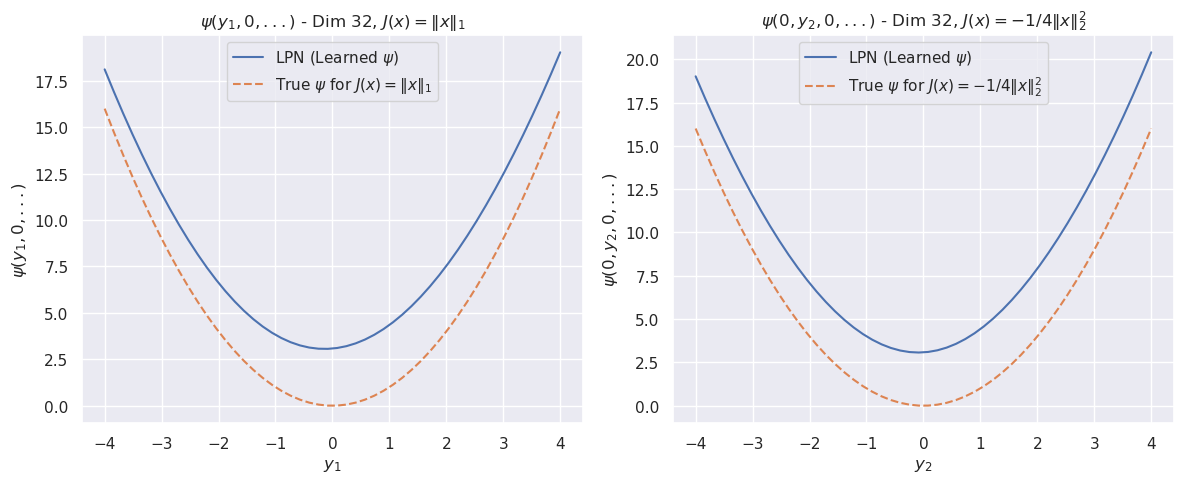

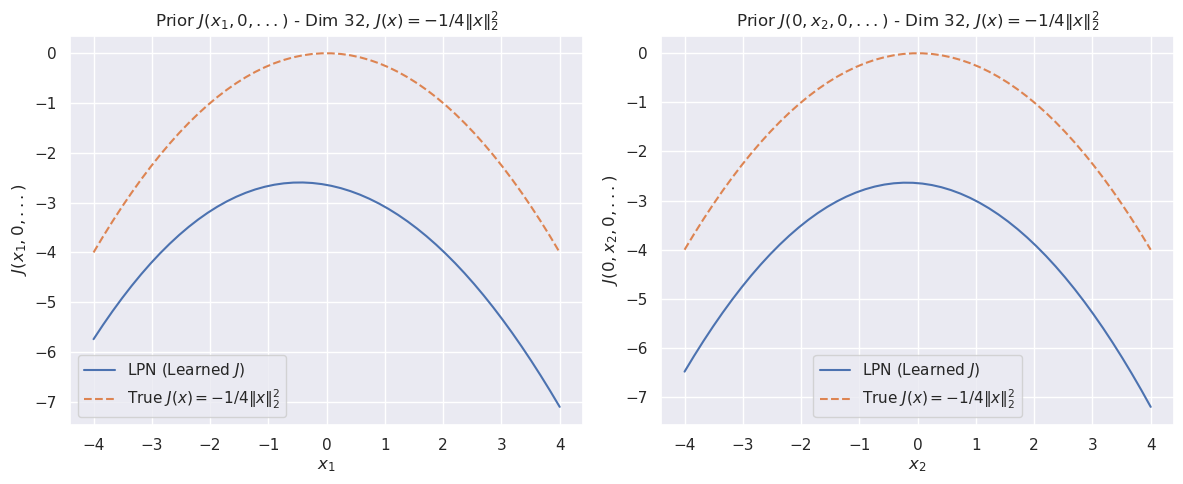

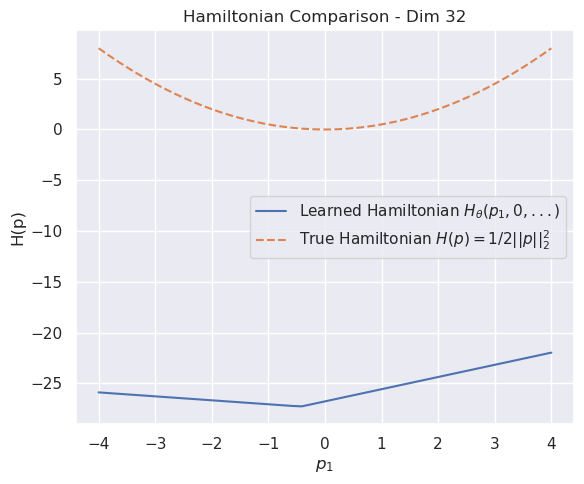

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=32) ---


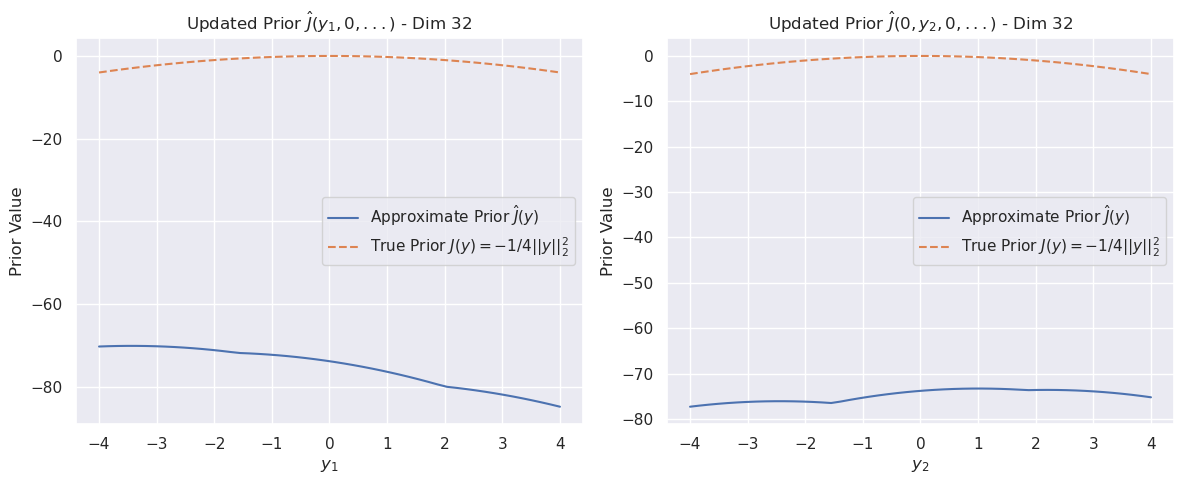

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_concave_quad(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = y_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 29524.287109375
iteration 0 loss 22989.50390625


iteration 500 loss 365.11505126953125


iteration 1000 loss 293.7070007324219


iteration 1500 loss 251.67074584960938


iteration 2000 loss 228.21694946289062


iteration 2500 loss 214.55690002441406


iteration 3000 loss 205.04220581054688


iteration 3500 loss 196.61463928222656


iteration 4000 loss 188.21981811523438


iteration 4500 loss 179.19491577148438


iteration 5000 loss 169.2932891845703


iteration 5500 loss 158.8634033203125


iteration 6000 loss 147.5704803466797


iteration 6500 loss 134.61924743652344


iteration 7000 loss 118.76728820800781


iteration 7500 loss 96.4135513305664


iteration 8000 loss 60.785648345947266


iteration 8500 loss 28.635196685791016


iteration 9000 loss 18.552398681640625


iteration 9500 loss 14.398674964904785


iteration 10000 loss 12.137524604797363


iteration 10500 loss 10.634913444519043


iteration 11000 loss 9.562264442443848


iteration 11500 loss 8.778338432312012


iteration 12000 loss 8.133332252502441


iteration 12500 loss 7.559531211853027


iteration 13000 loss 7.117402076721191


iteration 13500 loss 6.76108980178833


iteration 14000 loss 6.503185749053955


iteration 14500 loss 6.245889663696289


iteration 15000 loss 6.038211345672607


iteration 15500 loss 5.818789958953857


iteration 16000 loss 5.674779415130615


iteration 16500 loss 5.518595218658447


iteration 17000 loss 5.372677803039551


iteration 17500 loss 5.271184921264648


iteration 18000 loss 5.159520149230957


iteration 18500 loss 5.0602545738220215


iteration 19000 loss 4.985398769378662


iteration 19500 loss 4.90159273147583


iteration 20000 loss 4.819833278656006


iteration 20500 loss 4.755969524383545


iteration 21000 loss 4.68070125579834


iteration 21500 loss 4.623775005340576


iteration 22000 loss 4.574776649475098


iteration 22500 loss 4.5160136222839355


iteration 23000 loss 4.462385177612305


iteration 23500 loss 4.421371936798096


iteration 24000 loss 4.373735427856445


iteration 24500 loss 4.3224778175354


iteration 25000 loss 4.28791618347168


iteration 25500 loss 4.245481967926025


iteration 26000 loss 4.210455417633057


iteration 26500 loss 4.171460151672363


iteration 27000 loss 4.1359453201293945


iteration 27500 loss 4.095658302307129


iteration 28000 loss 4.067380905151367


iteration 28500 loss 4.035686492919922


iteration 29000 loss 4.0182294845581055


iteration 29500 loss 3.9813830852508545


iteration 30000 loss 3.9581427574157715


iteration 30500 loss 3.929469108581543


iteration 31000 loss 3.9004580974578857


iteration 31500 loss 3.8809096813201904


iteration 32000 loss 3.8595573902130127


iteration 32500 loss 3.8319714069366455


iteration 33000 loss 3.8157169818878174


iteration 33500 loss 3.7958154678344727


iteration 34000 loss 3.771711587905884


iteration 34500 loss 3.753443717956543


iteration 35000 loss 3.7348999977111816


iteration 35500 loss 3.7165706157684326


iteration 36000 loss 3.6970748901367188


iteration 36500 loss 3.679492950439453


iteration 37000 loss 3.6561975479125977


iteration 37500 loss 3.641807794570923


iteration 38000 loss 3.6281261444091797


iteration 38500 loss 3.6053287982940674


iteration 39000 loss 3.5899031162261963


iteration 39500 loss 3.5770421028137207


iteration 40000 loss 3.5620291233062744


iteration 40500 loss 3.5422744750976562


iteration 41000 loss 3.530672073364258


iteration 41500 loss 3.517425775527954


iteration 42000 loss 3.5010695457458496


iteration 42500 loss 3.487438201904297


iteration 43000 loss 3.4775941371917725


iteration 43500 loss 3.4664793014526367


iteration 44000 loss 3.453706979751587


iteration 44500 loss 3.439093589782715


iteration 45000 loss 3.4299802780151367


iteration 45500 loss 3.41886830329895


iteration 46000 loss 3.404703140258789


iteration 46500 loss 3.3947412967681885


iteration 47000 loss 3.385793685913086


iteration 47500 loss 3.3720250129699707


iteration 48000 loss 3.3621413707733154


iteration 48500 loss 3.3539931774139404


iteration 49000 loss 3.3444440364837646


iteration 49500 loss 3.332712411880493


iteration 50000 loss 3.3261425495147705


iteration 50500 loss 3.317906141281128


iteration 51000 loss 3.30751633644104


iteration 51500 loss 3.299131155014038


iteration 52000 loss 3.2926135063171387


iteration 52500 loss 3.2851710319519043


iteration 53000 loss 3.2755424976348877


iteration 53500 loss 3.2679030895233154


iteration 54000 loss 3.2621655464172363


iteration 54500 loss 3.255490303039551


iteration 55000 loss 3.2461278438568115


iteration 55500 loss 3.2385897636413574


iteration 56000 loss 3.232379674911499


iteration 56500 loss 3.2245447635650635


iteration 57000 loss 3.2157721519470215


iteration 57500 loss 3.2100746631622314


iteration 58000 loss 3.203381061553955


iteration 58500 loss 3.1961843967437744


iteration 59000 loss 3.1888835430145264


iteration 59500 loss 3.1839823722839355


iteration 60000 loss 3.1798269748687744


iteration 60500 loss 3.1702144145965576


iteration 61000 loss 3.1633143424987793


iteration 61500 loss 3.1582581996917725


iteration 62000 loss 3.153162956237793


iteration 62500 loss 3.144113302230835


iteration 63000 loss 3.1379177570343018


iteration 63500 loss 3.133298397064209


iteration 64000 loss 3.1287238597869873


iteration 64500 loss 3.1206390857696533


iteration 65000 loss 3.1143417358398438


iteration 65500 loss 3.10969877243042


iteration 66000 loss 3.1043288707733154


iteration 66500 loss 3.0955116748809814


iteration 67000 loss 3.091601610183716


iteration 67500 loss 3.0870330333709717


iteration 68000 loss 3.0831804275512695


iteration 68500 loss 3.0743517875671387


iteration 69000 loss 3.0695886611938477


iteration 69500 loss 3.064715623855591


iteration 70000 loss 3.0580999851226807


iteration 70500 loss 3.0520448684692383


iteration 71000 loss 3.0486040115356445


iteration 71500 loss 3.0447916984558105


iteration 72000 loss 3.0393800735473633


iteration 72500 loss 3.0321812629699707


iteration 73000 loss 3.0281741619110107


iteration 73500 loss 3.0239644050598145


iteration 74000 loss 3.0195069313049316


iteration 74500 loss 3.011920928955078


iteration 75000 loss 3.008786678314209


iteration 75500 loss 3.005249261856079


iteration 76000 loss 3.003997564315796


iteration 76500 loss 2.9950428009033203


iteration 77000 loss 2.9899239540100098


iteration 77500 loss 2.9874022006988525


iteration 78000 loss 2.9805777072906494


iteration 78500 loss 2.9835479259490967


iteration 79000 loss 2.971849203109741


iteration 79500 loss 2.968998670578003


iteration 80000 loss 2.964799642562866


iteration 80500 loss 2.959996223449707


iteration 81000 loss 2.9550678730010986


iteration 81500 loss 2.9518346786499023


iteration 82000 loss 2.9479355812072754


iteration 82500 loss 2.9433226585388184


iteration 83000 loss 2.9384467601776123


iteration 83500 loss 2.934580087661743


iteration 84000 loss 2.930938482284546


iteration 84500 loss 2.92439603805542


iteration 85000 loss 2.9212405681610107


iteration 85500 loss 2.917693614959717


iteration 86000 loss 2.9128425121307373


iteration 86500 loss 2.908611536026001


iteration 87000 loss 2.9059131145477295


iteration 87500 loss 2.9029626846313477


iteration 88000 loss 2.898244619369507


iteration 88500 loss 2.893852710723877


iteration 89000 loss 2.891554594039917


iteration 89500 loss 2.8886780738830566


iteration 90000 loss 2.885120153427124


iteration 90500 loss 2.880614757537842


iteration 91000 loss 2.8775453567504883


iteration 91500 loss 2.876145124435425


iteration 92000 loss 2.872683048248291


iteration 92500 loss 3.8527822494506836


iteration 93000 loss 2.8642795085906982


iteration 93500 loss 2.861989736557007


iteration 94000 loss 2.859312057495117


iteration 94500 loss 2.8554444313049316


iteration 95000 loss 2.8519716262817383


iteration 95500 loss 2.849914312362671


iteration 96000 loss 2.847623348236084


iteration 96500 loss 2.8441057205200195


iteration 97000 loss 2.873838424682617


iteration 97500 loss 2.8384132385253906


iteration 98000 loss 2.8366780281066895


iteration 98500 loss 2.8335163593292236


iteration 99000 loss 2.8346104621887207


iteration 99500 loss 2.8273637294769287


iteration 100000 loss 2.825343370437622


iteration 100500 loss 2.8227829933166504


iteration 101000 loss 2.820030927658081


iteration 101500 loss 2.816831588745117


iteration 102000 loss 2.815054178237915


iteration 102500 loss 2.8129780292510986


iteration 103000 loss 2.810455083847046


iteration 103500 loss 2.807413101196289


iteration 104000 loss 2.80523419380188


iteration 104500 loss 2.8034026622772217


iteration 105000 loss 2.8024752140045166


iteration 105500 loss 2.798172950744629


iteration 106000 loss 2.795907735824585


iteration 106500 loss 2.7940587997436523


iteration 107000 loss 2.7917590141296387


iteration 107500 loss 2.7894134521484375


iteration 108000 loss 2.786675453186035


iteration 108500 loss 2.7849693298339844


iteration 109000 loss 2.78281569480896


iteration 109500 loss 2.780120849609375


iteration 110000 loss 2.777752161026001


iteration 110500 loss 2.7760708332061768


iteration 111000 loss 2.773944616317749


iteration 111500 loss 2.773088216781616


iteration 112000 loss 2.768972635269165


iteration 112500 loss 2.7672078609466553


iteration 113000 loss 2.766866445541382


iteration 113500 loss 2.762267589569092


iteration 114000 loss 2.7603418827056885


iteration 114500 loss 2.758759021759033


iteration 115000 loss 2.756924867630005


iteration 115500 loss 2.7547521591186523


iteration 116000 loss 2.752305030822754


iteration 116500 loss 2.7509443759918213


iteration 117000 loss 2.7494966983795166


iteration 117500 loss 2.747864007949829


iteration 118000 loss 2.784290075302124


iteration 118500 loss 2.7431750297546387


iteration 119000 loss 2.741680860519409


iteration 119500 loss 2.7415335178375244


iteration 120000 loss 2.7375001907348633


iteration 120500 loss 2.735367774963379


iteration 121000 loss 2.7341525554656982


iteration 121500 loss 2.7350175380706787


iteration 122000 loss 2.730670690536499


iteration 122500 loss 2.729215145111084


iteration 123000 loss 2.726768732070923


iteration 123500 loss 2.7254326343536377


iteration 124000 loss 2.723726749420166


iteration 124500 loss 2.7227752208709717


iteration 125000 loss 2.719534397125244


iteration 125500 loss 2.7185492515563965


iteration 126000 loss 2.7165627479553223


iteration 126500 loss 2.7370967864990234


iteration 127000 loss 2.712505340576172


iteration 127500 loss 2.7111923694610596


iteration 128000 loss 2.7092623710632324


iteration 128500 loss 2.7070119380950928


iteration 129000 loss 2.7056925296783447


iteration 129500 loss 2.7044565677642822


iteration 130000 loss 2.702970266342163


iteration 130500 loss 2.7032978534698486


iteration 131000 loss 2.6990723609924316


iteration 131500 loss 2.6978955268859863


iteration 132000 loss 2.696845769882202


iteration 132500 loss 2.694805860519409


iteration 133000 loss 2.692518949508667


iteration 133500 loss 2.691448450088501


iteration 134000 loss 2.690208673477173


iteration 134500 loss 2.6897077560424805


iteration 135000 loss 2.6866772174835205


iteration 135500 loss 2.685034990310669


iteration 136000 loss 2.6837480068206787


iteration 136500 loss 2.682016611099243


iteration 137000 loss 2.6835343837738037


iteration 137500 loss 2.678616523742676


iteration 138000 loss 2.6775777339935303


iteration 138500 loss 2.676175832748413


iteration 139000 loss 2.6735026836395264


iteration 139500 loss 2.672536611557007


iteration 140000 loss 2.672213315963745


iteration 140500 loss 2.6699936389923096


iteration 141000 loss 2.668100595474243


iteration 141500 loss 2.6665995121002197


iteration 142000 loss 2.665367841720581


iteration 142500 loss 2.6639273166656494


iteration 143000 loss 2.662231683731079


iteration 143500 loss 2.6607630252838135


iteration 144000 loss 2.659709930419922


iteration 144500 loss 2.6584410667419434


iteration 145000 loss 2.6570019721984863


iteration 145500 loss 2.655095338821411


iteration 146000 loss 2.6540093421936035


iteration 146500 loss 2.652719259262085


iteration 147000 loss 2.6511175632476807


iteration 147500 loss 2.649466037750244


iteration 148000 loss 2.648324966430664


iteration 148500 loss 2.647061824798584


iteration 149000 loss 2.6455726623535156


iteration 149500 loss 2.6436679363250732


iteration 150000 loss 2.6425366401672363


iteration 150500 loss 2.6411361694335938


iteration 151000 loss 2.6393487453460693


iteration 151500 loss 2.6381022930145264


iteration 152000 loss 2.637117862701416


iteration 152500 loss 2.6359498500823975


iteration 153000 loss 2.6359126567840576


iteration 153500 loss 2.6327502727508545


iteration 154000 loss 2.631776809692383


iteration 154500 loss 2.6333603858947754


iteration 155000 loss 2.6292307376861572


iteration 155500 loss 2.627326011657715


iteration 156000 loss 2.626333236694336


iteration 156500 loss 2.625284194946289


iteration 157000 loss 2.623901844024658


iteration 157500 loss 2.6251070499420166


iteration 158000 loss 2.621004581451416


iteration 158500 loss 2.6199941635131836


iteration 159000 loss 2.6196117401123047


iteration 159500 loss 2.6168389320373535


iteration 160000 loss 2.6154897212982178


iteration 160500 loss 2.614534616470337


iteration 161000 loss 2.613325595855713


iteration 161500 loss 2.6118323802948


iteration 162000 loss 2.6102356910705566


iteration 162500 loss 2.609323024749756


iteration 163000 loss 2.6082656383514404


iteration 163500 loss 2.6068902015686035


iteration 164000 loss 2.8093581199645996


iteration 164500 loss 2.6039280891418457


iteration 165000 loss 2.605126142501831


iteration 165500 loss 2.602539539337158


iteration 166000 loss 2.5996556282043457


iteration 166500 loss 2.598803758621216


iteration 167000 loss 2.5979180335998535


iteration 167500 loss 2.596822500228882


iteration 168000 loss 2.594750165939331


iteration 168500 loss 2.5935258865356445


iteration 169000 loss 2.5924901962280273


iteration 169500 loss 2.59136700630188


iteration 170000 loss 2.5895209312438965


iteration 170500 loss 2.5884664058685303


iteration 171000 loss 2.5874810218811035


iteration 171500 loss 2.5866644382476807


iteration 172000 loss 2.5847151279449463


iteration 172500 loss 2.5834336280822754


iteration 173000 loss 2.582512140274048


iteration 173500 loss 2.5814156532287598


iteration 174000 loss 2.582834482192993


iteration 174500 loss 2.5785155296325684


iteration 175000 loss 2.577702760696411


iteration 175500 loss 2.5769429206848145


iteration 176000 loss 2.5758230686187744


iteration 176500 loss 2.574063539505005


iteration 177000 loss 2.572861671447754


iteration 177500 loss 2.572016477584839


iteration 178000 loss 2.571873664855957


iteration 178500 loss 2.569585084915161


iteration 179000 loss 2.5681419372558594


iteration 179500 loss 2.5672481060028076


iteration 180000 loss 2.5661604404449463


iteration 180500 loss 2.5650904178619385


iteration 181000 loss 2.563291549682617


iteration 181500 loss 2.5625579357147217


iteration 182000 loss 2.561669111251831


iteration 182500 loss 2.5611939430236816


iteration 183000 loss 2.559069871902466


iteration 183500 loss 2.557823657989502


iteration 184000 loss 2.556838035583496


iteration 184500 loss 2.555668354034424


iteration 185000 loss 2.561915874481201


iteration 185500 loss 2.553175210952759


iteration 186000 loss 2.5524303913116455


iteration 186500 loss 2.551724433898926


iteration 187000 loss 2.5494136810302734


iteration 187500 loss 2.5485689640045166


iteration 188000 loss 2.5475168228149414


iteration 188500 loss 2.546415090560913


iteration 189000 loss 2.544883966445923


iteration 189500 loss 2.5439977645874023


iteration 190000 loss 2.543210506439209


iteration 190500 loss 2.542196273803711


iteration 191000 loss 2.5402979850769043


iteration 191500 loss 2.539397954940796


iteration 192000 loss 2.538485527038574


iteration 192500 loss 2.5384397506713867


iteration 193000 loss 2.5359623432159424


iteration 193500 loss 2.5351758003234863


iteration 194000 loss 2.534212589263916


iteration 194500 loss 2.536365032196045


iteration 195000 loss 2.531625270843506


iteration 195500 loss 2.5308375358581543


iteration 196000 loss 2.529857635498047


iteration 196500 loss 2.5286219120025635


iteration 197000 loss 2.527297019958496


iteration 197500 loss 2.5265066623687744


iteration 198000 loss 2.5255863666534424


iteration 198500 loss 2.525104522705078


iteration 199000 loss 2.5230257511138916


iteration 199500 loss 2.522221803665161


iteration 200000 loss 2.521390199661255


iteration 200500 loss 2.5202925205230713


iteration 201000 loss 2.5188217163085938


iteration 201500 loss 2.518214702606201


iteration 202000 loss 2.5176000595092773


iteration 202500 loss 2.5192646980285645


iteration 203000 loss 2.517786741256714


iteration 203500 loss 2.5142757892608643


iteration 204000 loss 2.5135726928710938


iteration 204500 loss 2.512769937515259


iteration 205000 loss 2.5116209983825684


iteration 205500 loss 2.5104682445526123


iteration 206000 loss 2.5098116397857666


iteration 206500 loss 2.5089974403381348


iteration 207000 loss 2.507988691329956


iteration 207500 loss 2.5079147815704346


iteration 208000 loss 2.5058975219726562


iteration 208500 loss 2.5052146911621094


iteration 209000 loss 2.504455089569092


iteration 209500 loss 2.5028233528137207


iteration 210000 loss 2.502218246459961


iteration 210500 loss 2.501697540283203


iteration 211000 loss 2.5015065670013428


iteration 211500 loss 2.499687910079956


iteration 212000 loss 2.49861216545105


iteration 212500 loss 2.49794602394104


iteration 213000 loss 2.4971346855163574


iteration 213500 loss 2.496049642562866


iteration 214000 loss 2.4949467182159424


iteration 214500 loss 2.4943654537200928


iteration 215000 loss 2.4936957359313965


iteration 215500 loss 2.49463152885437


iteration 216000 loss 2.4918160438537598


iteration 216500 loss 2.4908287525177


iteration 217000 loss 2.4901297092437744


iteration 217500 loss 2.4893605709075928


iteration 218000 loss 2.488114833831787


iteration 218500 loss 2.4872891902923584


iteration 219000 loss 2.486571788787842


iteration 219500 loss 2.4861223697662354


iteration 220000 loss 2.4846770763397217


iteration 220500 loss 2.4837117195129395


iteration 221000 loss 2.4830172061920166


iteration 221500 loss 2.4820992946624756


iteration 222000 loss 2.481755018234253


iteration 222500 loss 2.4803435802459717


iteration 223000 loss 2.4796366691589355


iteration 223500 loss 2.478806257247925


iteration 224000 loss 2.4779245853424072


iteration 224500 loss 2.476957082748413


iteration 225000 loss 2.4763646125793457


iteration 225500 loss 2.475619077682495


iteration 226000 loss 2.4751698970794678


iteration 226500 loss 2.4736850261688232


iteration 227000 loss 2.473090887069702


iteration 227500 loss 2.472482681274414


iteration 228000 loss 2.472382068634033


iteration 228500 loss 2.4870588779449463


iteration 229000 loss 2.46979022026062


iteration 229500 loss 2.469163656234741


iteration 230000 loss 2.468210458755493


iteration 230500 loss 2.480325222015381


iteration 231000 loss 2.466597318649292


iteration 231500 loss 2.465968608856201


iteration 232000 loss 2.465172290802002


iteration 232500 loss 2.4642372131347656


iteration 233000 loss 2.463435173034668


iteration 233500 loss 2.4629268646240234


iteration 234000 loss 2.463090419769287


iteration 234500 loss 2.461021900177002


iteration 235000 loss 2.4602549076080322


iteration 235500 loss 2.4595940113067627


iteration 236000 loss 2.459414005279541


iteration 236500 loss 2.4579222202301025


iteration 237000 loss 2.457183361053467


iteration 237500 loss 2.4570937156677246


iteration 238000 loss 2.457432746887207


iteration 238500 loss 2.455003023147583


iteration 239000 loss 2.454083204269409


iteration 239500 loss 2.4534645080566406


iteration 240000 loss 2.4528000354766846


iteration 240500 loss 2.4521398544311523


iteration 241000 loss 2.4511280059814453


iteration 241500 loss 2.4508414268493652


iteration 242000 loss 2.450502634048462


iteration 242500 loss 2.4493842124938965


iteration 243000 loss 2.448154926300049


iteration 243500 loss 2.4475791454315186


iteration 244000 loss 2.4468603134155273


iteration 244500 loss 2.450437068939209


iteration 245000 loss 2.4452526569366455


iteration 245500 loss 2.44472599029541


iteration 246000 loss 2.444430112838745


iteration 246500 loss 2.4436302185058594


iteration 247000 loss 2.442434310913086


iteration 247500 loss 2.441979169845581


iteration 248000 loss 2.441436767578125


iteration 248500 loss 2.441649913787842


iteration 249000 loss 2.4398269653320312


iteration 249500 loss 2.439197540283203


iteration 250000 loss 2.438746690750122


iteration 250500 loss 2.4382100105285645


iteration 251000 loss 2.4390745162963867


iteration 251500 loss 2.436955690383911


iteration 252000 loss 2.4359681606292725


iteration 252500 loss 2.435417413711548


iteration 253000 loss 2.4347877502441406


iteration 253500 loss 2.4337799549102783


iteration 254000 loss 2.433310031890869


iteration 254500 loss 2.4328420162200928


iteration 255000 loss 2.435297966003418


iteration 255500 loss 3.416208505630493


iteration 256000 loss 2.430694580078125


iteration 256500 loss 2.430272102355957


iteration 257000 loss 2.4295811653137207


iteration 257500 loss 2.4331014156341553


iteration 258000 loss 2.4281136989593506


iteration 258500 loss 2.427560329437256


iteration 259000 loss 2.4268901348114014


iteration 259500 loss 2.430737257003784


iteration 260000 loss 2.42555832862854


iteration 260500 loss 2.4250504970550537


iteration 261000 loss 2.425119638442993


iteration 261500 loss 2.4250645637512207


iteration 262000 loss 2.4229674339294434


iteration 262500 loss 2.422496795654297


iteration 263000 loss 2.4235620498657227


iteration 263500 loss 2.4211506843566895


iteration 264000 loss 2.4204089641571045


iteration 264500 loss 2.419919490814209


iteration 265000 loss 2.419966459274292


iteration 265500 loss 2.4201717376708984


iteration 266000 loss 2.4178478717803955


iteration 266500 loss 2.4173531532287598


iteration 267000 loss 2.416738986968994


iteration 267500 loss 2.4159858226776123


iteration 268000 loss 2.415278911590576


iteration 268500 loss 2.4147822856903076


iteration 269000 loss 2.414519786834717


iteration 269500 loss 2.4134092330932617


iteration 270000 loss 2.412842035293579


iteration 270500 loss 2.4124062061309814


iteration 271000 loss 2.413172960281372


iteration 271500 loss 2.411769151687622


iteration 272000 loss 2.677473783493042


iteration 272500 loss 2.409940242767334


iteration 273000 loss 2.4095170497894287


iteration 273500 loss 2.408998966217041


iteration 274000 loss 2.410036563873291


iteration 274500 loss 2.4075562953948975


iteration 275000 loss 2.407027006149292


iteration 275500 loss 2.4064464569091797


iteration 276000 loss 2.4061312675476074


iteration 276500 loss 2.4050121307373047


iteration 277000 loss 2.4045753479003906


iteration 277500 loss 2.404254198074341


iteration 278000 loss 2.4081497192382812


iteration 278500 loss 2.4046409130096436


iteration 279000 loss 2.4021430015563965


iteration 279500 loss 2.4017176628112793


iteration 280000 loss 2.4015166759490967


iteration 280500 loss 2.4002277851104736


iteration 281000 loss 2.399714469909668


iteration 281500 loss 2.399207830429077


iteration 282000 loss 2.3987467288970947


iteration 282500 loss 2.3980484008789062


iteration 283000 loss 2.397263526916504


iteration 283500 loss 2.3968982696533203


iteration 284000 loss 2.396024465560913


iteration 284500 loss 2.3953373432159424


iteration 285000 loss 2.3948581218719482


iteration 285500 loss 2.3952667713165283


iteration 286000 loss 2.393510103225708


iteration 286500 loss 2.3928472995758057


iteration 287000 loss 2.3926773071289062


iteration 287500 loss 2.391847610473633


iteration 288000 loss 2.393505811691284


iteration 288500 loss 2.3903753757476807


iteration 289000 loss 2.3899447917938232


iteration 289500 loss 2.3898839950561523


iteration 290000 loss 2.3906145095825195


iteration 290500 loss 2.3880157470703125


iteration 291000 loss 2.387603759765625


iteration 291500 loss 2.387343645095825


iteration 292000 loss 2.3866820335388184


iteration 292500 loss 2.3857650756835938


iteration 293000 loss 2.385254144668579


iteration 293500 loss 2.3848302364349365


iteration 294000 loss 2.3847718238830566


iteration 294500 loss 2.383676052093506


iteration 295000 loss 2.382965087890625


iteration 295500 loss 2.3825159072875977


iteration 296000 loss 2.38227915763855


iteration 296500 loss 2.386742115020752


iteration 297000 loss 2.380626678466797


iteration 297500 loss 2.380150079727173


iteration 298000 loss 2.3812954425811768


iteration 298500 loss 2.3800222873687744


iteration 299000 loss 2.3782012462615967


iteration 299500 loss 2.3776979446411133


iteration 300000 loss 2.3770811557769775


iteration 300500 loss 2.376281261444092


iteration 301000 loss 2.3758370876312256


iteration 301500 loss 2.3758440017700195


iteration 302000 loss 2.3763115406036377


iteration 302500 loss 2.374697208404541


iteration 303000 loss 2.373460054397583


iteration 303500 loss 2.373342990875244


iteration 304000 loss 2.3730597496032715


iteration 304500 loss 2.371803045272827


iteration 305000 loss 2.371079921722412


iteration 305500 loss 2.370666027069092


iteration 306000 loss 2.370199203491211


iteration 306500 loss 2.3698787689208984


iteration 307000 loss 2.3699703216552734


iteration 307500 loss 2.3683035373687744


iteration 308000 loss 2.3680803775787354


iteration 308500 loss 2.367356538772583


iteration 309000 loss 3.5308260917663574


iteration 309500 loss 2.3659892082214355


iteration 310000 loss 2.3658957481384277


iteration 310500 loss 2.3678956031799316


iteration 311000 loss 2.3642125129699707


iteration 311500 loss 2.363771915435791


iteration 312000 loss 2.363754987716675


iteration 312500 loss 2.365238904953003


iteration 313000 loss 2.756289482116699


iteration 313500 loss 2.36151123046875


iteration 314000 loss 2.3611092567443848


iteration 314500 loss 2.36175537109375


iteration 315000 loss 2.361187219619751


iteration 315500 loss 2.3591666221618652


iteration 316000 loss 2.3587443828582764


iteration 316500 loss 2.358501672744751


iteration 317000 loss 2.3575496673583984


iteration 317500 loss 2.423144578933716


iteration 318000 loss 2.3563694953918457


iteration 318500 loss 2.3560421466827393


iteration 319000 loss 2.3574752807617188


iteration 319500 loss 2.355949640274048


iteration 320000 loss 2.3541643619537354


iteration 320500 loss 2.3537352085113525


iteration 321000 loss 2.3532512187957764


iteration 321500 loss 2.3528475761413574


iteration 322000 loss 2.3519296646118164


iteration 322500 loss 2.3515284061431885


iteration 323000 loss 2.351142406463623


iteration 323500 loss 2.3506758213043213


iteration 324000 loss 2.3497684001922607


iteration 324500 loss 2.3493776321411133


iteration 325000 loss 2.3490190505981445


iteration 325500 loss 2.348459243774414


iteration 326000 loss 2.3483736515045166


iteration 326500 loss 2.3471240997314453


iteration 327000 loss 2.3467159271240234


iteration 327500 loss 2.3465535640716553


iteration 328000 loss 2.345595598220825


iteration 328500 loss 2.3449783325195312


iteration 329000 loss 2.344597578048706


iteration 329500 loss 2.344268798828125


iteration 330000 loss 2.344081401824951


iteration 330500 loss 2.343245506286621


iteration 331000 loss 2.3424596786499023


iteration 331500 loss 2.3420989513397217


iteration 332000 loss 2.341700315475464


iteration 332500 loss 2.341792106628418


iteration 333000 loss 2.3422279357910156


iteration 333500 loss 2.3399219512939453


iteration 334000 loss 2.3395533561706543


iteration 334500 loss 2.3391547203063965


iteration 335000 loss 2.3389179706573486


iteration 335500 loss 2.3379018306732178


iteration 336000 loss 2.337406873703003


iteration 336500 loss 2.337500810623169


iteration 337000 loss 2.3362503051757812


iteration 337500 loss 2.3356740474700928


iteration 338000 loss 2.3352901935577393


iteration 338500 loss 2.3348259925842285


iteration 339000 loss 2.334585189819336


iteration 339500 loss 2.3336055278778076


iteration 340000 loss 2.333254098892212


iteration 340500 loss 2.3328464031219482


iteration 341000 loss 2.3323607444763184


iteration 341500 loss 2.3331031799316406


iteration 342000 loss 2.3311595916748047


iteration 342500 loss 2.330777168273926


iteration 343000 loss 2.3304290771484375


iteration 343500 loss 2.330202341079712


iteration 344000 loss 2.329089403152466


iteration 344500 loss 2.3286783695220947


iteration 345000 loss 2.3304741382598877


iteration 345500 loss 2.3285961151123047


iteration 346000 loss 2.327037811279297


iteration 346500 loss 2.3266799449920654


iteration 347000 loss 2.3262674808502197


iteration 347500 loss 2.325878620147705


iteration 348000 loss 2.325453758239746


iteration 348500 loss 2.32454252243042


iteration 349000 loss 2.324826955795288


iteration 349500 loss 2.3236453533172607


iteration 350000 loss 2.323789119720459


iteration 350500 loss 2.3224589824676514


iteration 351000 loss 2.3221161365509033


iteration 351500 loss 2.3221991062164307


iteration 352000 loss 2.323712110519409


iteration 352500 loss 2.320481538772583


iteration 353000 loss 2.3200361728668213


iteration 353500 loss 2.319768190383911


iteration 354000 loss 2.3195598125457764


iteration 354500 loss 2.3183741569519043


iteration 355000 loss 2.3180313110351562


iteration 355500 loss 2.31779146194458


iteration 356000 loss 2.3185198307037354


iteration 356500 loss 2.3174047470092773


iteration 357000 loss 2.315981388092041


iteration 357500 loss 2.3155882358551025


iteration 358000 loss 2.3151955604553223


iteration 358500 loss 2.320507049560547


iteration 359000 loss 2.313875436782837


iteration 359500 loss 2.3134512901306152


iteration 360000 loss 2.3129758834838867


iteration 360500 loss 2.3122737407684326


iteration 361000 loss 2.3118467330932617


iteration 361500 loss 2.3116390705108643


iteration 362000 loss 2.3109378814697266


iteration 362500 loss 2.3102636337280273


iteration 363000 loss 2.309886932373047


iteration 363500 loss 2.3094558715820312


iteration 364000 loss 2.30895733833313


iteration 364500 loss 2.308291435241699


iteration 365000 loss 2.307903528213501


iteration 365500 loss 2.307576894760132


iteration 366000 loss 2.307310104370117


iteration 366500 loss 2.3062901496887207


iteration 367000 loss 2.3059494495391846


iteration 367500 loss 2.3089282512664795


iteration 368000 loss 2.305311918258667


iteration 368500 loss 2.304478883743286


iteration 369000 loss 2.3039662837982178


iteration 369500 loss 2.3034520149230957


iteration 370000 loss 2.3111417293548584


iteration 370500 loss 2.302306890487671


iteration 371000 loss 2.30189847946167


iteration 371500 loss 2.3015964031219482


iteration 372000 loss 2.3007631301879883


iteration 372500 loss 2.300281286239624


iteration 373000 loss 2.2998600006103516


iteration 373500 loss 2.299673557281494


iteration 374000 loss 2.3003990650177


iteration 374500 loss 2.2983102798461914


iteration 375000 loss 2.299316644668579


iteration 375500 loss 2.297492027282715


iteration 376000 loss 2.2971527576446533


iteration 376500 loss 2.296342611312866


iteration 377000 loss 2.296018123626709


iteration 377500 loss 2.295654535293579


iteration 378000 loss 2.3009111881256104


iteration 378500 loss 2.294501781463623


iteration 379000 loss 2.294071674346924


iteration 379500 loss 2.2937092781066895


iteration 380000 loss 2.293304920196533


iteration 380500 loss 2.2928202152252197


iteration 381000 loss 2.2921297550201416


iteration 381500 loss 2.2917795181274414


iteration 382000 loss 2.2913639545440674


iteration 382500 loss 2.2908027172088623


iteration 383000 loss 2.291830539703369


iteration 383500 loss 2.2897772789001465


iteration 384000 loss 2.2897260189056396


iteration 384500 loss 2.2888402938842773


iteration 385000 loss 2.289457321166992


iteration 385500 loss 2.287731647491455


iteration 386000 loss 2.28732967376709


iteration 386500 loss 2.286834239959717


iteration 387000 loss 2.286104679107666


iteration 387500 loss 2.2857329845428467


iteration 388000 loss 2.285341262817383


iteration 388500 loss 2.2854504585266113


iteration 389000 loss 2.3055269718170166


iteration 389500 loss 2.2837045192718506


iteration 390000 loss 2.2832963466644287


iteration 390500 loss 2.2842819690704346


iteration 391000 loss 2.282114028930664


iteration 391500 loss 2.281679153442383


iteration 392000 loss 2.281980037689209


iteration 392500 loss 2.281142234802246


iteration 393000 loss 2.2822022438049316


iteration 393500 loss 2.2796688079833984


iteration 394000 loss 2.279325246810913


iteration 394500 loss 2.2789642810821533


iteration 395000 loss 2.2784571647644043


iteration 395500 loss 2.279391050338745


iteration 396000 loss 2.2772796154022217


iteration 396500 loss 2.276873826980591


iteration 397000 loss 2.2777340412139893


iteration 397500 loss 2.2763450145721436


iteration 398000 loss 2.275320529937744


iteration 398500 loss 2.2749500274658203


iteration 399000 loss 2.276401996612549


iteration 399500 loss 2.2842257022857666


iteration 400000 loss 2.2733101844787598


iteration 400500 loss 2.2729132175445557


iteration 401000 loss 2.2725260257720947


iteration 401500 loss 2.273322105407715


iteration 402000 loss 2.2713277339935303


iteration 402500 loss 2.270998477935791


iteration 403000 loss 2.2755908966064453


iteration 403500 loss 2.2718636989593506


iteration 404000 loss 2.2694501876831055


iteration 404500 loss 2.269014358520508


iteration 405000 loss 2.2686679363250732


iteration 405500 loss 2.2692203521728516


iteration 406000 loss 2.267430305480957


iteration 406500 loss 2.2670845985412598


iteration 407000 loss 2.266718626022339


iteration 407500 loss 2.2677910327911377


iteration 408000 loss 2.265890598297119


iteration 408500 loss 2.265235185623169


iteration 409000 loss 2.266301155090332


iteration 409500 loss 2.26554012298584


iteration 410000 loss 2.2650625705718994


iteration 410500 loss 2.2633554935455322


iteration 411000 loss 2.2630109786987305


iteration 411500 loss 2.2644455432891846


iteration 412000 loss 2.262377977371216


iteration 412500 loss 2.2614519596099854


iteration 413000 loss 2.2610812187194824


iteration 413500 loss 2.260775327682495


iteration 414000 loss 2.260072708129883


iteration 414500 loss 2.259561061859131


iteration 415000 loss 2.2591800689697266


iteration 415500 loss 2.259096622467041


iteration 416000 loss 2.2647881507873535


iteration 416500 loss 2.257737159729004


iteration 417000 loss 2.25759220123291


iteration 417500 loss 2.256972074508667


iteration 418000 loss 2.2563791275024414


iteration 418500 loss 2.255869150161743


iteration 419000 loss 2.2554900646209717


iteration 419500 loss 2.2550888061523438


iteration 420000 loss 2.8457326889038086


iteration 420500 loss 2.25407075881958


iteration 421000 loss 2.2622499465942383


iteration 421500 loss 2.2549667358398438


iteration 422000 loss 2.252596378326416


iteration 422500 loss 2.25226092338562


iteration 423000 loss 2.2567715644836426


iteration 423500 loss 2.251638650894165


iteration 424000 loss 2.250821590423584


iteration 424500 loss 2.2505123615264893


iteration 425000 loss 2.2570576667785645


iteration 425500 loss 2.2498183250427246


iteration 426000 loss 2.250854730606079


iteration 426500 loss 2.2487168312072754


iteration 427000 loss 2.254056215286255


iteration 427500 loss 2.256051778793335


iteration 428000 loss 2.247312545776367


iteration 428500 loss 2.246910572052002


iteration 429000 loss 2.246540069580078


iteration 429500 loss 2.24637508392334


iteration 430000 loss 2.2455334663391113


iteration 430500 loss 2.2452051639556885


iteration 431000 loss 2.2463135719299316


iteration 431500 loss 2.2445144653320312


iteration 432000 loss 2.243765115737915


iteration 432500 loss 2.243422269821167


iteration 433000 loss 2.243680000305176


iteration 433500 loss 2.243004322052002


iteration 434000 loss 2.242021083831787


iteration 434500 loss 2.2415878772735596


iteration 435000 loss 2.2425854206085205


iteration 435500 loss 2.240800619125366


iteration 436000 loss 2.240185022354126


iteration 436500 loss 2.2398734092712402


iteration 437000 loss 2.2396819591522217


iteration 437500 loss 2.24040150642395


iteration 438000 loss 2.2386767864227295


iteration 438500 loss 2.2380874156951904


iteration 439000 loss 2.237668991088867


iteration 439500 loss 2.2425734996795654


iteration 440000 loss 2.2367372512817383


iteration 440500 loss 2.238274574279785


iteration 441000 loss 2.2358322143554688


iteration 441500 loss 2.2353270053863525


iteration 442000 loss 2.2350549697875977


iteration 442500 loss 2.2353053092956543


iteration 443000 loss 2.234105348587036


iteration 443500 loss 2.2336416244506836


iteration 444000 loss 2.233304738998413


iteration 444500 loss 2.233025312423706


iteration 445000 loss 2.2323660850524902


iteration 445500 loss 2.2319447994232178


iteration 446000 loss 2.2316131591796875


iteration 446500 loss 2.2312493324279785


iteration 447000 loss 2.230713129043579


iteration 447500 loss 2.230212450027466


iteration 448000 loss 2.2298805713653564


iteration 448500 loss 2.229703664779663


iteration 449000 loss 2.230220317840576


iteration 449500 loss 2.228525161743164


iteration 450000 loss 2.2281839847564697


iteration 450500 loss 2.227778911590576


iteration 451000 loss 2.227773666381836


iteration 451500 loss 2.2268593311309814


iteration 452000 loss 2.2264504432678223


iteration 452500 loss 2.226083993911743


iteration 453000 loss 2.225539445877075


iteration 453500 loss 2.225480318069458


iteration 454000 loss 2.225062608718872


iteration 454500 loss 2.2242088317871094


iteration 455000 loss 2.223905324935913


iteration 455500 loss 2.2235846519470215


iteration 456000 loss 2.2235069274902344


iteration 456500 loss 2.2225894927978516


iteration 457000 loss 2.222269058227539


iteration 457500 loss 2.221881151199341


iteration 458000 loss 2.2222933769226074


iteration 458500 loss 2.220947027206421


iteration 459000 loss 2.2224743366241455


iteration 459500 loss 2.2203257083892822


iteration 460000 loss 2.219616651535034


iteration 460500 loss 2.219298839569092


iteration 461000 loss 2.2193777561187744


iteration 461500 loss 2.2199482917785645


iteration 462000 loss 2.2180230617523193


iteration 462500 loss 2.2176151275634766


iteration 463000 loss 2.217294931411743


iteration 463500 loss 2.216754913330078


iteration 464000 loss 2.216303825378418


iteration 464500 loss 2.215963125228882


iteration 465000 loss 2.216895341873169


iteration 465500 loss 2.215162754058838


iteration 466000 loss 2.2146124839782715


iteration 466500 loss 2.2142834663391113


iteration 467000 loss 2.2148008346557617


iteration 467500 loss 2.2134294509887695


iteration 468000 loss 2.2129809856414795


iteration 468500 loss 2.2132015228271484


iteration 469000 loss 2.2129416465759277


iteration 469500 loss 2.2122621536254883


iteration 470000 loss 2.2113568782806396


iteration 470500 loss 2.2140190601348877


iteration 471000 loss 2.2112114429473877


iteration 471500 loss 2.2132468223571777


iteration 472000 loss 2.209688901901245


iteration 472500 loss 2.2093849182128906


iteration 473000 loss 2.2092740535736084


iteration 473500 loss 2.2099719047546387


iteration 474000 loss 2.2081050872802734


iteration 474500 loss 2.2078068256378174


iteration 475000 loss 2.2075772285461426


iteration 475500 loss 2.2145140171051025


iteration 476000 loss 2.206552743911743


iteration 476500 loss 2.2062320709228516


iteration 477000 loss 2.218219518661499


iteration 477500 loss 2.2093698978424072


iteration 478000 loss 2.204935312271118


iteration 478500 loss 2.204618453979492


iteration 479000 loss 2.2042665481567383


iteration 479500 loss 2.2056667804718018


iteration 480000 loss 2.203326940536499


iteration 480500 loss 2.2030389308929443


iteration 481000 loss 2.2030763626098633


iteration 481500 loss 2.202301502227783


iteration 482000 loss 2.2018163204193115


iteration 482500 loss 2.2045369148254395


iteration 483000 loss 2.207780122756958


iteration 483500 loss 2.200532913208008


iteration 484000 loss 2.200216293334961


iteration 484500 loss 2.2000529766082764


iteration 485000 loss 2.199793815612793


iteration 485500 loss 2.199427366256714


iteration 486000 loss 2.198679208755493


iteration 486500 loss 2.1984124183654785


iteration 487000 loss 2.2003448009490967


iteration 487500 loss 2.1980791091918945


iteration 488000 loss 2.1971242427825928


iteration 488500 loss 2.199496030807495


iteration 489000 loss 2.196678876876831


iteration 489500 loss 2.1959316730499268


iteration 490000 loss 2.195605516433716


iteration 490500 loss 2.198218584060669


iteration 491000 loss 2.1950316429138184


iteration 491500 loss 2.1944284439086914


iteration 492000 loss 2.1941258907318115


iteration 492500 loss 2.1977622509002686


iteration 493000 loss 2.1932406425476074


iteration 493500 loss 2.1929519176483154


iteration 494000 loss 2.1925339698791504


iteration 494500 loss 2.1924705505371094


iteration 495000 loss 2.1916933059692383


iteration 495500 loss 2.191403388977051


iteration 496000 loss 2.192162036895752


iteration 496500 loss 2.1906988620758057


iteration 497000 loss 2.1901943683624268


iteration 497500 loss 2.1898841857910156


iteration 498000 loss 2.1913554668426514


iteration 498500 loss 2.1967103481292725


iteration 499000 loss 2.1887013912200928


iteration 499500 loss 2.188385009765625


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


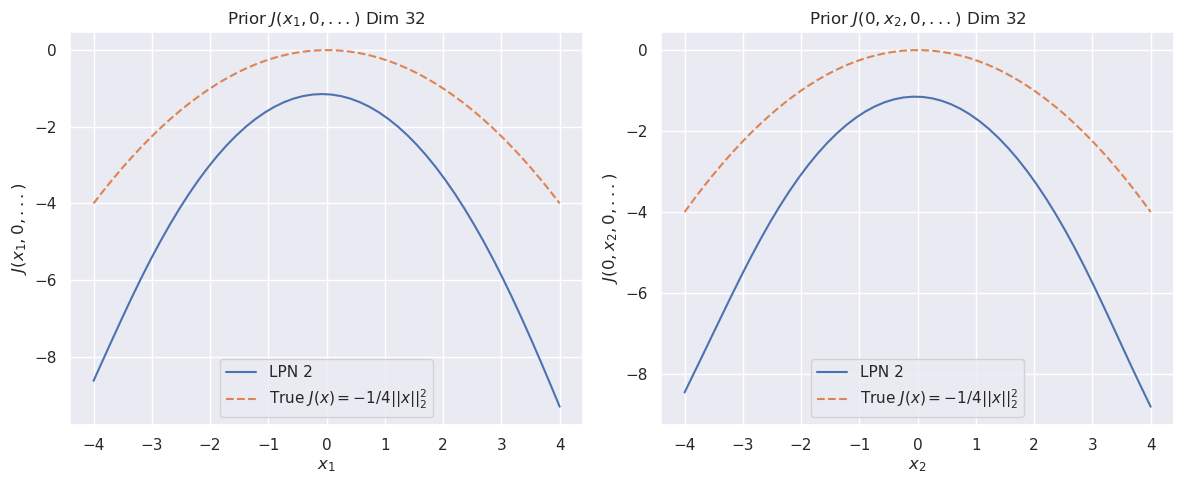

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

L1 loss -- Train

In [12]:

# --- Train and Plot with L1 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 29816.869140625


iteration 500 loss 366.24139404296875


iteration 0 loss 290.62799072265625


iteration 500 loss 242.2095947265625


iteration 1000 loss 214.33279418945312


iteration 1500 loss 199.00575256347656


iteration 2000 loss 189.46080017089844


iteration 2500 loss 181.27268981933594


iteration 3000 loss 172.6822967529297


iteration 3500 loss 163.32949829101562


iteration 4000 loss 153.07675170898438


iteration 4500 loss 141.76585388183594


iteration 5000 loss 129.10670471191406


iteration 5500 loss 114.4871597290039


iteration 6000 loss 96.38326263427734


iteration 6500 loss 72.36219787597656


iteration 7000 loss 44.84088134765625


iteration 7500 loss 28.13315773010254


iteration 8000 loss 19.95996856689453


iteration 8500 loss 15.556793212890625


iteration 9000 loss 13.179965019226074


iteration 9500 loss 11.741209983825684


iteration 10000 loss 10.651326179504395


iteration 10500 loss 9.818498611450195


iteration 11000 loss 9.213688850402832


iteration 11500 loss 8.78573989868164


iteration 12000 loss 8.431951522827148


iteration 12500 loss 8.135899543762207


iteration 13000 loss 7.899194240570068


iteration 13500 loss 7.671693325042725


iteration 14000 loss 7.4809184074401855


iteration 14500 loss 7.2437310218811035


iteration 15000 loss 7.068624973297119


iteration 15500 loss 6.880006790161133


iteration 16000 loss 6.7183451652526855


iteration 16500 loss 6.528419494628906


iteration 17000 loss 6.368178844451904


iteration 17500 loss 6.196829319000244


iteration 18000 loss 6.052414894104004


iteration 18500 loss 5.90270471572876


iteration 19000 loss 5.764850616455078


iteration 19500 loss 5.639763355255127


iteration 20000 loss 5.542651653289795


iteration 20500 loss 5.392820835113525


iteration 21000 loss 5.27922248840332


iteration 21500 loss 5.18898344039917


iteration 22000 loss 5.083967685699463


iteration 22500 loss 4.992525577545166


iteration 23000 loss 4.897528171539307


iteration 23500 loss 4.816894054412842


iteration 24000 loss 4.737402439117432


iteration 24500 loss 4.655436038970947


iteration 25000 loss 4.593966484069824


iteration 25500 loss 4.523879528045654


iteration 26000 loss 4.457651138305664


iteration 26500 loss 4.400938987731934


iteration 27000 loss 4.337014675140381


iteration 27500 loss 4.283299446105957


iteration 28000 loss 4.224017143249512


iteration 28500 loss 4.164327144622803


iteration 29000 loss 4.122192859649658


iteration 29500 loss 4.074038028717041


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
loss -10.718302726745605


loss -98.22631072998047


loss -144.20460510253906


loss -177.2185516357422


loss -200.41722106933594


loss -212.5082550048828


loss -216.8077392578125


loss -217.8848419189453


loss -218.0714874267578


loss -218.09201049804688


loss -218.09329223632812


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


loss -218.09332275390625


final mse:  1.2116883496560149e-08
max, min: 2.7525227 -2.7744343
loss -10.718302726745605


loss -96.95903015136719


loss -144.3824462890625


loss -180.9297332763672


loss -207.89926147460938


loss -223.9393768310547


loss -230.67669677734375


loss -232.60964965820312


loss -233.00088500976562


loss -233.05775451660156


loss -233.06344604492188


loss -233.06378173828125


loss -233.0637969970703


loss -233.06378173828125


loss -233.06378173828125


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.06381225585938


loss -233.0637969970703


loss -233.0637969970703


loss -233.06381225585938


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.0637969970703


loss -233.06378173828125


loss -233.0637969970703


loss -233.0637969970703


loss -233.06378173828125


loss -233.0637969970703


loss -233.06378173828125


loss -233.0637969970703


loss -233.0637969970703


final mse:  1.845134534050885e-08
max, min: 2.946135 -2.9545224


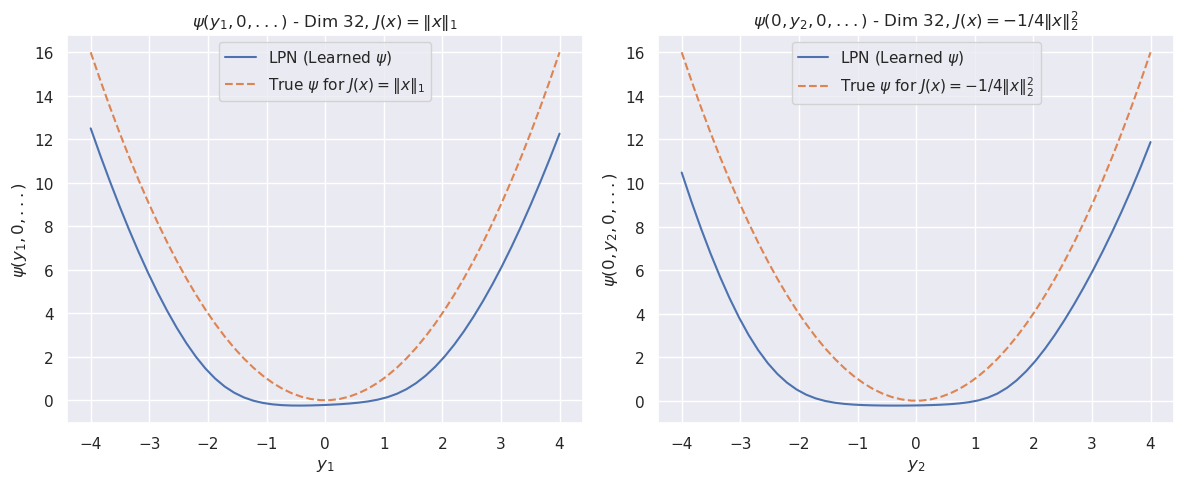

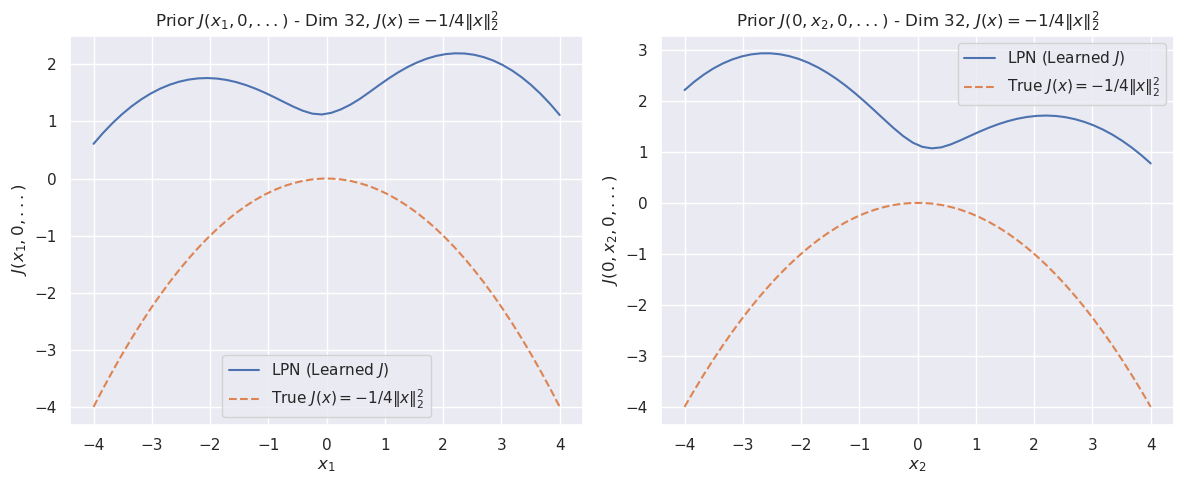

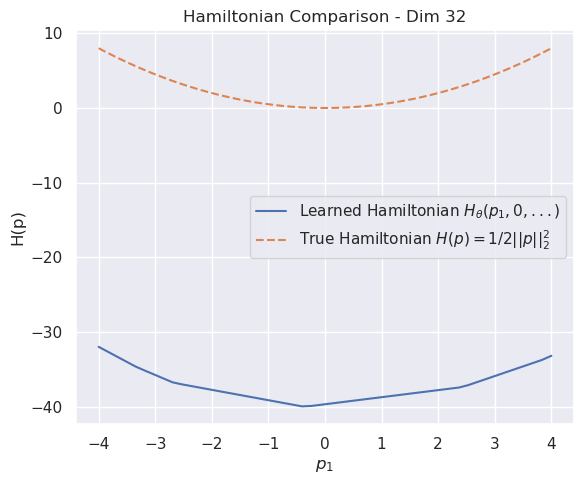

In [13]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)


Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [14]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [15]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [16]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [17]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [18]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [19]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)